# EDA 

Author: hshin337@gatech.edu  
Date: 2/5/2026  




## Findings

- Category repair was critical: many markets had blank categories; keyword-based tagging expanded Crypto markets from 340 to 48,752, confirming large mislabeling.
- Crypto markets ramp up after 2020-10; pre-2020 activity is sparse, so early periods may need smoothing or default values for any index.
- Market creation is highly clustered; daily market count spikes align with high-volume days, indicating bursts of user attention.
- Volume distribution is heavy‑tailed (log scale needed); a small set of markets dominates volume.
- The top 20 markets by volume are mostly BTC price range or short‑horizon “up/down” questions, suggesting speculative micro‑markets drive activity.
- Trading duration varies widely; many markets are short‑lived while others stay active longer, so duration normalization is necessary.
- `trade_count` and `volume` are positively related; both capture activity but are not identical.
- `active_trade_ratio` shows many markets trading only a fraction of their open window; low ratios highlight “stale” markets.
- Token price volatility (`std_token_price`) varies by market and is useful for capturing instability or disagreement in odds.
- The composite Crypto Poly Index tracks daily shifts in participation and volatility; daily min/mean/max shows large dispersion across markets.


1. Use Ploymaket data  
    - Crypto Market interest indicator 
    - Before the year 2020, value set as 0.5

2. Incomplete category need to be reviewed  
    - `bitcoin|btc|crypto|eth|bsv|bch|ada|xrp` for market category classification
    - Before Crypto category count 340
    - After Crypto category count 48,752

3. How to interpret data as an indicator
    - Sentiment score [0, 1]
    - What else?


Data range  
- Crypto market
  - Start date 2020-10-02 20:00:04  
  - End data 2025-12-10 05:32:21 

- Markets_summary
  - Start date 2025-04-07 08:05:19 
  - End data 2026-01-05 05:55:21 

- Markets_odds
  - Start date 2023-01-24 00:00:12 
  - End data 2026-01-05 01:02:10 

**Crypto Poly Index (`crypto_poly_index`)**

**Rationale Behind the Index**
- **Goal**: summarize crypto market interest into a single $[0,1]$ signal from Polymarket activity.
- **Inputs**: `trade_count`, `volume`, `std_token_price`, `active_trade_ratio`.
- **Transformations**:
  - Log transform on `trade_count`, `volume`, `std_token_price` to reduce heavy‑tail effects.
  - Min‑max normalization to make metrics comparable and bounded.
- **Aggregation**:
  - Weighted sum of normalized metrics, clipped to $[0,1]$.
  - Final weights used: `trade_count` 0.35, `volume` 0.35, `std_token_price` 0.0, `active_trade_ratio` 0.30.
- **Interpretation**:
  - Higher values indicate stronger engagement and sustained trading activity.
  - Low values reflect sparse trading, low volume, or short active windows.

**active_trade_ratio**
- Definition: actual_market_trade_duration_minutes / market_open_duration_minutes, clipped to [0, 1].
- `market_open_duration_minutes` = end_date - created_at (how long the market was open).
- `actual_market_trade_duration_minutes` = last_trade - first_trade (how long it actually traded).
- Interpretation: 1.0 means trading spanned the full open window; lower values indicate trading happened only in a smaller portion of the market’s lifetime.
- Null/invalid handling: set to `None` when open duration is missing or non‑positive.

## EDA Story (Polymarket Crypto)

Agenda
- 1) Data sources and scope
- 2) Load and normalize timestamps
- 3) Repair categories and filter crypto markets
- 4) Coverage checks and date ranges
- 5) Market-level exploration
- 6) Join with summary and derive activity metrics
- 7) Odds dynamics and price volatility
- 8) Build the Crypto Poly Index
- 9) Outputs and open questions

### 1) Data sources and scope
- Use Polymarket parquet files: markets, summary, odds, and event_stats
- Focus on crypto-related markets as a proxy for crypto interest/sentiment

### 2) Load and normalize timestamps
- Load Polymarket datasets and inspect column schemas
- Infer epoch units and convert to proper datetimes for trade and odds timestamps

### 3) Repair categories and filter crypto markets
- Re-label empty categories using keyword matches in `question`
- Validate the change by counting Crypto markets before and after

### 4) Coverage checks and date ranges
- Report min/max timestamps for crypto markets, summary, and odds
- Note that summary/odds start later than early crypto markets

### 5) Market-level exploration
- Market count by category (bar chart)
- Crypto market creation timeline (histogram)
- Sample crypto questions for qualitative checks
- Daily volume and market count trends over time
- Distributions: volume, top volume markets, trading duration
- Correlation check between volume and trade_count

### 6) Join with summary and derive activity metrics
- Join crypto markets with summary on `market_id`
- Compute market open duration and actual trading duration
- Derive `active_trade_ratio` and clip to [0, 1]

### 7) Odds dynamics and price volatility
- Plot odds for a sample market (market_id 798778)
- Compute `std_token_price` for each market and join back

### 8) Build the Crypto Poly Index
- Log-transform and min-max normalize key metrics
- Weighted composite index in [0, 1] from trade_count, volume, std_token_price, active_trade_ratio
- Plot index over time (scatter + daily min/mean/max)

### 9) Outputs and open questions
- Save index dataset to parquet for downstream modeling
- Open questions: best weighting scheme and how to interpret index as sentiment

In [1]:
import os
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from eda_starter_template import (
    load_bitcoin_data, 
    load_polymarket_data, 
    analyze_btc_metrics, 
    analyze_polymarket_summary, 
    plot_btc_price, 
    plot_polymarket_volume
)

# --- Configuration ---
# Robustly determine the project root directory
SCRIPT_DIR = Path().resolve()
PROJECT_ROOT = SCRIPT_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = SCRIPT_DIR / "plots"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

print(f"Project root directory: {PROJECT_ROOT}")

Project root directory: C:\Users\hyuns\workspace\GT-MSA-Spring-2026-Team-09


## Ploymarket
 
markets_path = datadir / "finance_politics_markets.parquet"  
odds_path = datadir / "finance_politics_odds_history.parquet"  
summary_path = datadir / "finance_politics_summary.parquet"  

In [2]:

dict_ploymarket = load_polymarket_data(POLYMARKET_DIR)
df_markets = dict_ploymarket['markets']
df_markets_summary = dict_ploymarket['summary']
df_markets_odds = dict_ploymarket['odds']
df_event_stats = pl.read_parquet(POLYMARKET_DIR / "finance_politics_event_stats.parquet")

def _infer_epoch_unit(series: pl.Series) -> str:
    v = series.drop_nulls().cast(pl.Int64)[0]
    if v < 10 ** 11:
        return "s"
    if v < 10 ** 14:
        return "ms"
    if v < 10 ** 17:
        return "us"
    return "ns"

def fix_epoch_cols(df: pl.DataFrame, cols: list[str]) -> pl.DataFrame:
    unit = _infer_epoch_unit(df.select(cols[0]).to_series())
    return df.with_columns(
        [pl.from_epoch(pl.col(c).cast(pl.Int64), time_unit=unit).alias(c) for c in cols]
    )

df_markets_summary = fix_epoch_cols(df_markets_summary, ["first_trade", "last_trade"])
df_markets_odds = fix_epoch_cols(df_markets_odds, ["timestamp"])

Loading Polymarket data from C:\Users\hyuns\workspace\GT-MSA-Spring-2026-Team-09\data\Polymarket...
[Memory] Before loading Polymarket data: 209.79 MB
Loaded 78321 markets.
Loaded 2143181 odds history records.
Loaded 78321 summary records.
[Memory] After loading Polymarket data: 406.21 MB (Δ 196.41 MB)


In [3]:
print("", df_markets.columns, "\n\n",\
      df_markets_summary.columns, "\n\n", \
        df_markets_odds.columns,"\n\n", \
            df_event_stats.columns)

 ['market_id', 'question', 'slug', 'event_slug', 'category', 'volume', 'active', 'closed', 'created_at', 'end_date'] 

 ['market_id', 'question', 'slug', 'volume', 'active', 'token_count', 'trade_count', 'first_trade', 'last_trade'] 

 ['market_id', 'token_id', 'timestamp', 'price'] 

 ['event_slug', 'market_count', 'total_volume', 'first_market_start', 'last_market_end']


In [4]:
from typing import List, Tuple

# --- Helper: keyword classifier ---
def classify_markets_by_keywords(df: pl.DataFrame) -> pl.DataFrame:
    rules: List[Tuple[str, str]] = [
        ("Ukraine-Russia", r"\b(ukraine|russia|putin|zelensky|kiev|kyiv|donbas|luhansk|crimea|invasion|war in ukraine)\b"),
        ("Coronavirus", r"\b(coronavirus|covid-19|covid19|covid|pandemic|sars-cov-2|vaccine|vaccination|omicron|delta|lockdown)\b"),
        ("Tech", r"\b(tech|technology|ai|artificial intelligence|machine learning|ml|deep learning|semiconductor|chip|startup|silicon valley|nvidia|intel|gpu)\b"),
        ("Pop-Culture", r"\b(movie|film|tv|television|album|song|singer|actor|actress|celebrity|k-pop|netflix|disney|oscars|grammys|pop culture)\b"),
        ("Business", r"\b(stock|stocks|market|earnings|ipo|merger|acquisition|acquire|ceo|cfo|profit|revenue|dow jones|s&p|nasdaq)\b"),
        ("US-Current-Affairs", r"\b(biden|trump|white house|congress|senate|house of representatives|supreme court|federal reserve|fbi|doj|department of justice)\b"),
        ("Global Politics", r"\b(united nations|united-nations|un|diplomacy|sanction|sanctions|nato|eu|european union|g20|foreign policy|geopolitic(s)?)\b"),
        ("Politics", r"\b(politic(s)?|election(s)?|campaign|vote|ballot|parliament|minister|prime minister)\b"),
        # ("Trump", r"\b(trump|donald trump|president trump)\b"),
    ]

    # Robust preprocessing: fill nulls and lowercase question once
    df = df.with_columns(
        pl.col("category").fill_null("").alias("category"),
        pl.col("question").fill_null("").str.to_lowercase().alias("__q_lc"),
    )

    # Only fill blanks (empty string after fill)
    is_blank_expr = lambda: (pl.col("category") == "")

    for label, pattern in rules:
        df = df.with_columns(
            pl.when(is_blank_expr() & pl.col("__q_lc").str.contains(pattern))
              .then(pl.lit(label))
              .otherwise(pl.col("category"))
              .alias("category")
        )

    df = df.drop("__q_lc")
    return df

# --- Existing Crypto repair + apply classifier ---
# Print before count
print("Before Crypto category count", df_markets.filter(pl.col("category") == "Crypto").height)

# Ensure same preprocessing for the crypto-specific rule
df_markets = df_markets.with_columns(
    pl.col("category").fill_null("").alias("category"),
    pl.col("question").fill_null("").str.to_lowercase().alias("__q_lc"),
)

df_markets = df_markets.with_columns(
    pl.when(
        (pl.col("category") == "") &
        (pl.col("__q_lc").str.contains(r"\b(bitcoin|btc|crypto|eth|bsv|bch|ada|xrp)\b"))
    ).then(pl.lit("Crypto"))
    .otherwise(pl.col("category"))
    .alias("category")
)

df_markets = df_markets.drop("__q_lc")

# Print after Crypto-only repair
print("After Crypto category count (post-crypto-repair)", df_markets.filter(pl.col("category") == "Crypto").height)

# Apply broader keyword classifier to remaining blanks
df_markets = classify_markets_by_keywords(df_markets)

# Optional: summary counts after full labeling
print("Categories distribution after keyword fill:")
print(df_markets.group_by("category").agg(pl.count().alias("count")).sort("count", descending=True).to_pandas())

Before Crypto category count 340
After Crypto category count (post-crypto-repair) 27662
Categories distribution after keyword fill:
              category  count
0                       38174
1               Crypto  27662
2   US-Current-Affairs   7743
3             Politics   3376
4             Business    500
5       Ukraine-Russia    335
6   US-current-affairs    265
7                 Tech    149
8      Global Politics     64
9     Ukraine & Russia     20
10         Coronavirus     19
11         Pop-Culture      9
12        Pop-Culture       4
13        Coronavirus-      1


C:\Users\hyuns\AppData\Local\Temp\ipykernel_20040\1051670242.py:66: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(df_markets.group_by("category").agg(pl.count().alias("count")).sort("count", descending=True).to_pandas())


Crypto Market volume

<Axes: title={'center': 'Number of Markets by Category'}, ylabel='category'>

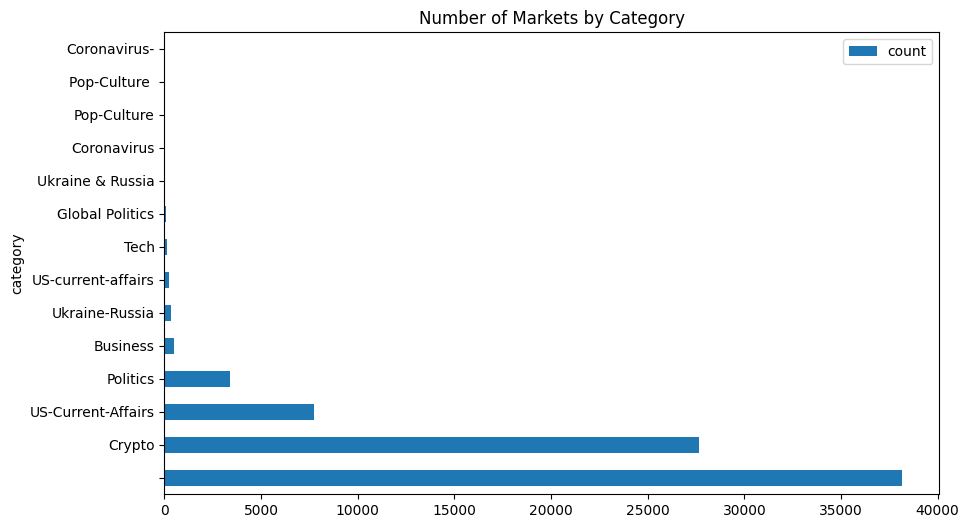

In [5]:
df_markets.group_by('category').agg(pl.len().alias('count')).sort('count', descending=True).\
    to_pandas().plot(x='category', y='count', kind='barh', title='Number of Markets by Category', figsize=(10, 6))

Let see Trump related markets

In [6]:
# Apply broader keyword classifier to remaining blanks
df_markets = classify_markets_by_keywords(df_markets)

# Force Trump override regardless of existing category (user request)
trump_pattern = r"\b(trump|donald trump|president trump)\b"
df_markets = df_markets.with_columns(
    pl.col("question").fill_null("").str.to_lowercase().alias("__q_lc_trump")
)
df_markets = df_markets.with_columns(
    pl.when(pl.col("__q_lc_trump").str.contains(trump_pattern))
      .then(pl.lit("Trump"))
      .otherwise(pl.col("category"))
      .alias("category")
)
df_markets = df_markets.drop("__q_lc_trump")

# Optional: summary counts after full labeling
print("Categories distribution after keyword fill:")
print(df_markets.group_by("category").agg(pl.count().alias("count")).sort("count", descending=True).to_pandas())

Categories distribution after keyword fill:
              category  count
0                       38174
1               Crypto  27414
2                Trump   7230
3             Politics   3375
4   US-Current-Affairs   1198
5             Business    488
6   US-current-affairs    207
7       Ukraine-Russia     68
8      Global Politics     64
9                 Tech     60
10    Ukraine & Russia     20
11         Coronavirus     11
12         Pop-Culture      7
13        Pop-Culture       4
14        Coronavirus-      1


C:\Users\hyuns\AppData\Local\Temp\ipykernel_20040\4255267478.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(df_markets.group_by("category").agg(pl.count().alias("count")).sort("count", descending=True).to_pandas())


<Axes: title={'center': 'Number of Markets by Category'}, ylabel='category'>

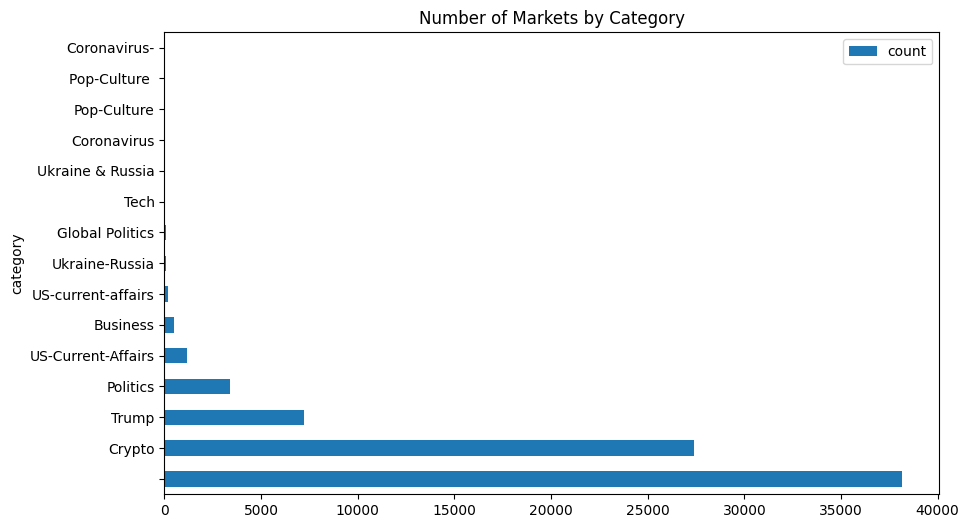

In [7]:
df_markets.group_by('category').agg(pl.len().alias('count')).sort('count', descending=True).\
    to_pandas().plot(x='category', y='count', kind='barh', title='Number of Markets by Category', figsize=(10, 6))

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

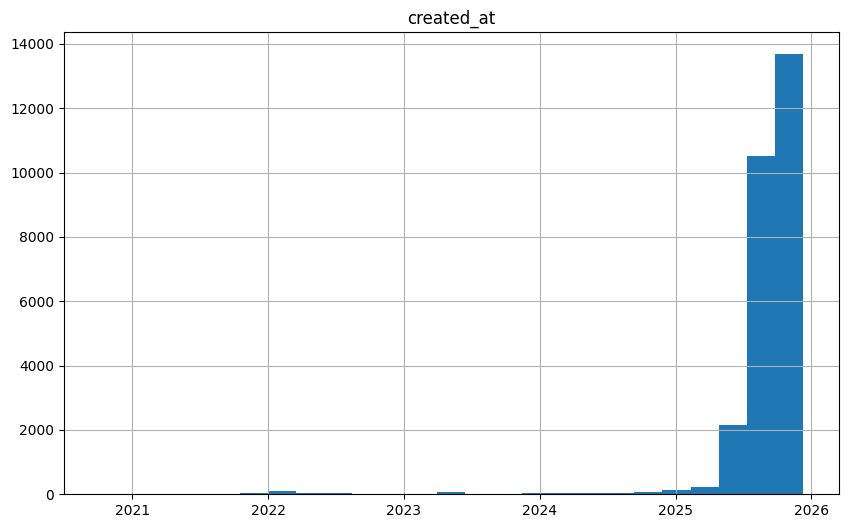

In [8]:
crypto_markets = df_markets.filter(pl.col('category') == 'Crypto').sort('created_at', descending=False)  
crypto_markets.to_pandas().hist(column='created_at', bins=25, figsize=(10, 6))

Date ranges


In [9]:
print('Crypot market\nStart date', crypto_markets['created_at'].min(), '\nEnd data', crypto_markets['created_at'].max(), '\n')

print('df_markets_summary\nStart date', df_markets_summary['first_trade'].min(), '\nEnd data', df_markets_summary['first_trade'].max(), '\n')

print('df_markets_odds\nStart date', df_markets_odds['timestamp'].min(), '\nEnd data', df_markets_odds['timestamp'].max(), '\n')

Crypot market
Start date 2020-10-02 20:00:04 
End data 2025-12-10 05:32:19 

df_markets_summary
Start date 2025-04-07 08:05:19 
End data 2026-01-05 05:55:21 

df_markets_odds
Start date 2023-01-24 00:00:12 
End data 2026-01-05 01:02:10 



In [10]:
# df_markets.select(['question', 'created_at', 'category','volume']).sort('volume', descending=True).head(20)
print("Random 20 Crypto Market Questions:")
print("=" * 80)
for idx, row in enumerate(df_markets.select(['question', 'created_at', 'category','volume']).sort('volume', descending=True).head(20).to_pandas().itertuples(), 1):
    q = f"{row.question} ({row.category})"
    print(f"{idx:02d}. [{row.created_at.strftime('%Y-%m-%d')}] {q:<120}{row.volume:>15,.1f}")

Random 20 Crypto Market Questions:
01. [2024-01-04] Will Donald Trump win the 2024 US Presidential Election? (Trump)                                                        1,531,479,284.5
02. [2024-01-04] Will Kamala Harris win the 2024 US Presidential Election? (Politics)                                                    1,037,039,118.2
03. [2024-11-01] Will Donald Trump be inaugurated? (Trump)                                                                                 400,409,526.9
04. [2024-11-07] Will Nicolae Ciucă win the 2024 Romanian Presidential election? (Politics)                                                326,507,670.6
05. [2024-01-06] Will any other Republican Politician win the 2024 US Presidential Election? (Politics)                                    241,655,099.9
06. [2024-01-09] Kamala Harris wins the popular vote? (Politics)                                                                           163,779,786.6
07. [2024-01-05] Will Michelle Obama win the 20

Market question samples

In [11]:
# Randomly sample 10 questions from crypto markets
sampled_questions = crypto_markets.select(['question', 'created_at', 'category','volume']).sort('volume', descending=True).head(20)
print("Random 20 Crypto Market Questions:")
print("=" * 80)
for idx, row in enumerate(sampled_questions.to_pandas().itertuples(), 1):
    q = f"{row.question} ({row.category})"
    print(f"{idx:02d}. [{row.created_at.strftime('%Y-%m-%d')}] {q:<70}{row.volume:>15,.1f}")

Random 20 Crypto Market Questions:
01. [2024-11-08] Will Bitcoin hit $100k in November? (Crypto)                             28,587,434.4
02. [2024-03-04] Will Bitcoin hit $100k in 2024? (Crypto)                                 22,807,235.9
03. [2025-07-14] Will Satoshi move any Bitcoin in 2025? (Crypto)                          16,290,996.5
04. [2025-10-01] Will Bitcoin reach $200k in October? (Crypto)                            15,617,197.2
05. [2025-11-01] Will Bitcoin reach $200,000 in November? (Crypto)                        13,588,620.8
06. [2023-12-01] Bitcoin ETF approved by Jan 15? (Crypto)                                 12,622,418.4
07. [2024-12-30] Will Bitcoin reach $150,000 by December 31, 2025? (Crypto)               12,479,153.6
08. [2024-12-02] Will Bitcoin reach $110,000 in December? (Crypto)                        10,676,795.0
09. [2024-12-30] Will Bitcoin reach $200,000 by December 31, 2025? (Crypto)               10,389,919.2
10. [2024-12-13] Bitcoin above $100,00

In [12]:
crypto_markets.group_by(pl.col('event_slug')).agg(pl.len().alias('count')).sort('count', descending=True)

event_slug,count
str,u32
"""what-price-will-bitcoin-hit-in…",28
"""what-price-will-bitcoin-hit-in…",21
"""what-price-will-bitcoin-hit-in…",20
"""what-price-will-bitcoin-hit-be…",19
"""what-price-will-bitcoin-hit-in…",19
…,…
"""will-ethereum-dip-below-2000-b…",1
"""bitcoin-up-or-down-october-27-…",1
"""btc-updown-15m-1760593500""",1


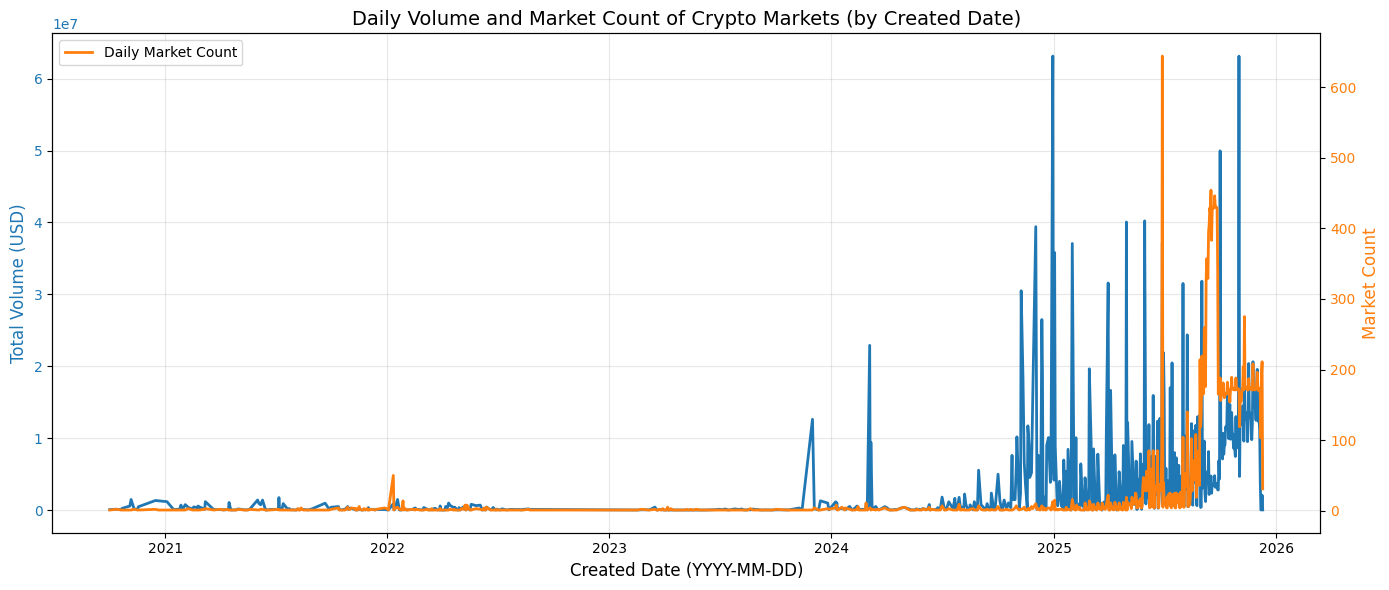

In [13]:
# Group crypto markets by created_at date and sum volume
crypto_daily_volume = (
    crypto_markets
    .with_columns(pl.col('created_at').cast(pl.Date).alias('date'))
    .group_by('date')
    .agg(pl.col('volume').sum().alias('daily_volume'), pl.col('market_id').count().alias('daily_market_count'))
    .sort('date')
)

# Plot with dual y-axis
plt.figure(figsize=(14, 6))
pd_crypto_daily_volume = crypto_daily_volume.to_pandas()

ax1 = plt.gca()
ax1.plot(pd_crypto_daily_volume['date'], pd_crypto_daily_volume['daily_volume'], color='tab:blue', linewidth=2, label='Daily Volume')
ax1.set_xlabel('Created Date (YYYY-MM-DD)', fontsize=12)
ax1.set_ylabel('Total Volume (USD)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(pd_crypto_daily_volume['date'], pd_crypto_daily_volume['daily_market_count'], 
         color='tab:orange', linewidth=2, label='Daily Market Count')
ax2.set_ylabel('Market Count', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Daily Volume and Market Count of Crypto Markets (by Created Date)', fontsize=14)
plt.legend()
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.tight_layout()
plt.show()

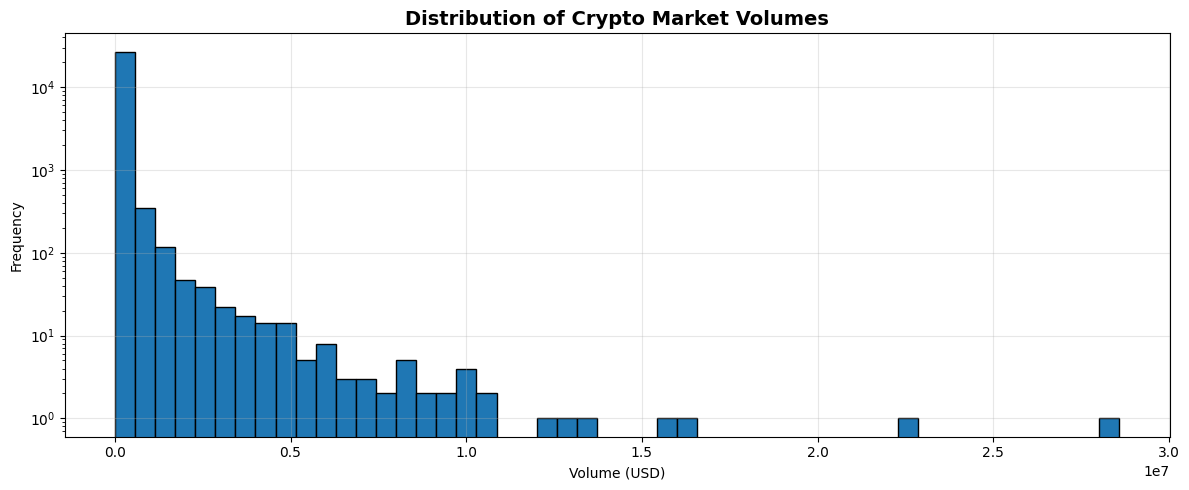

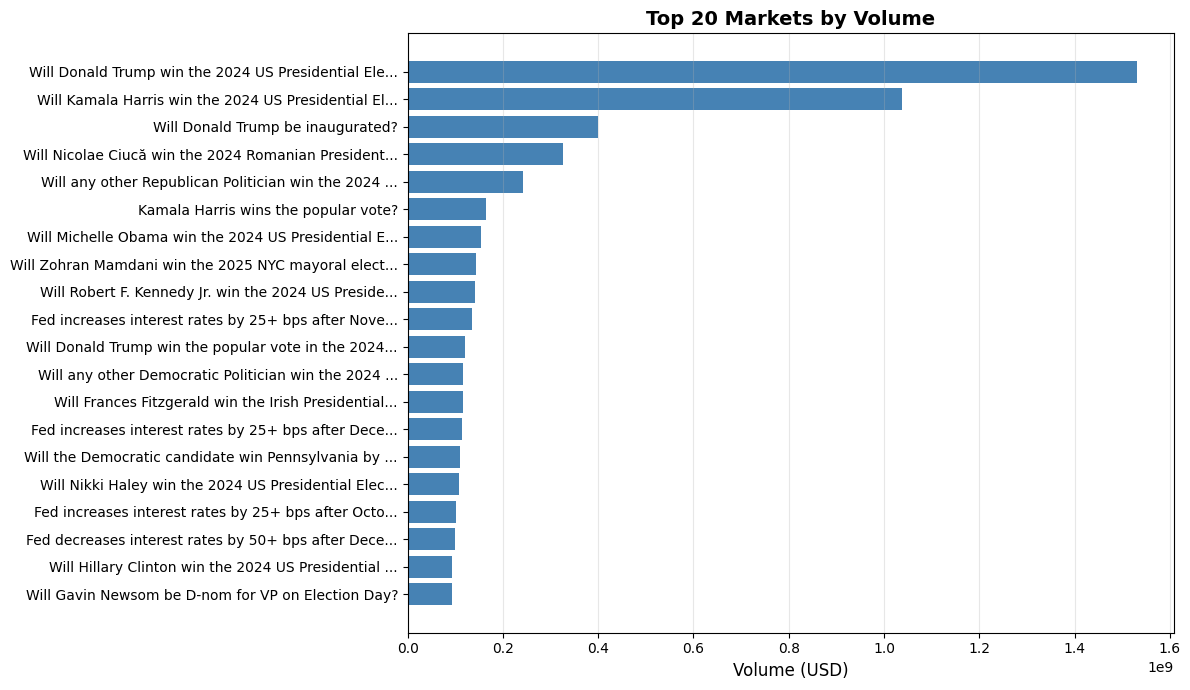

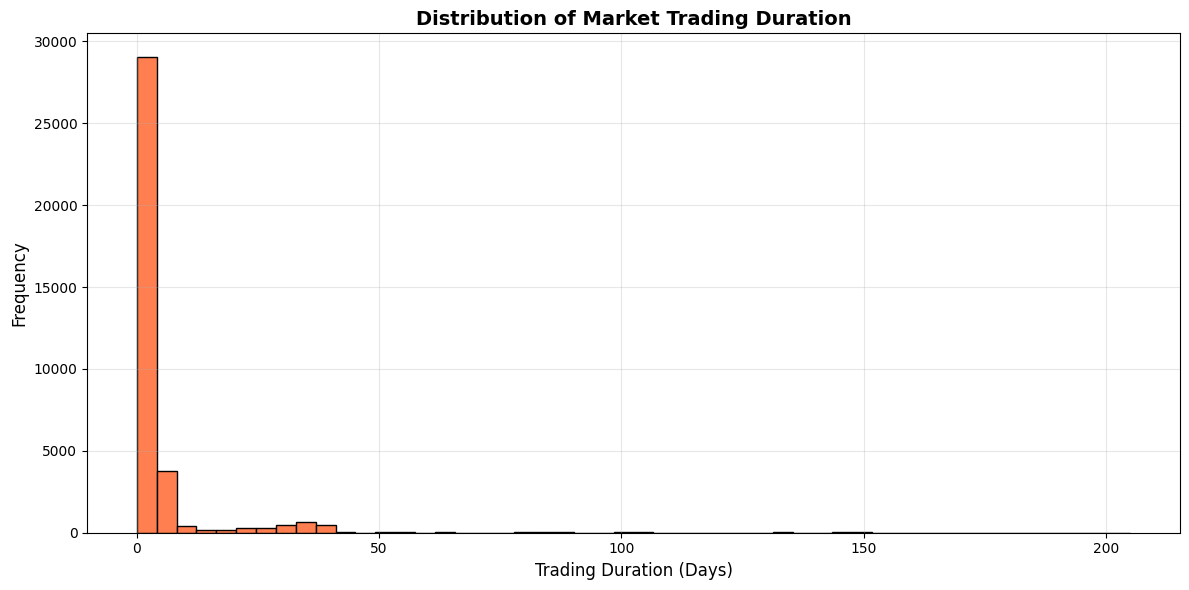

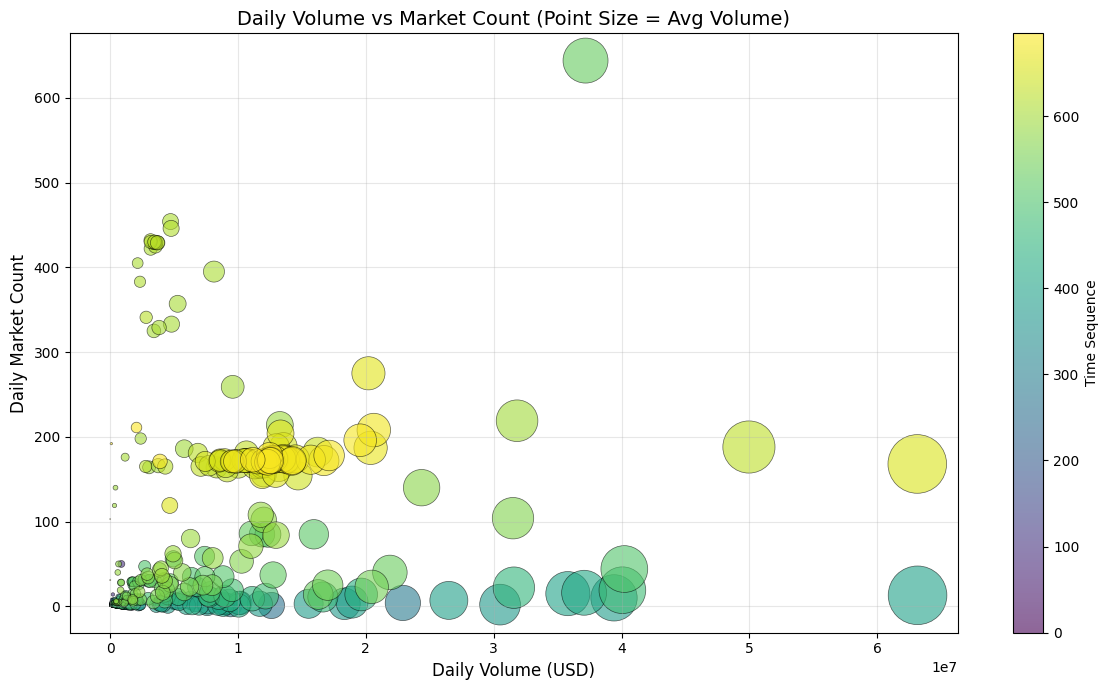

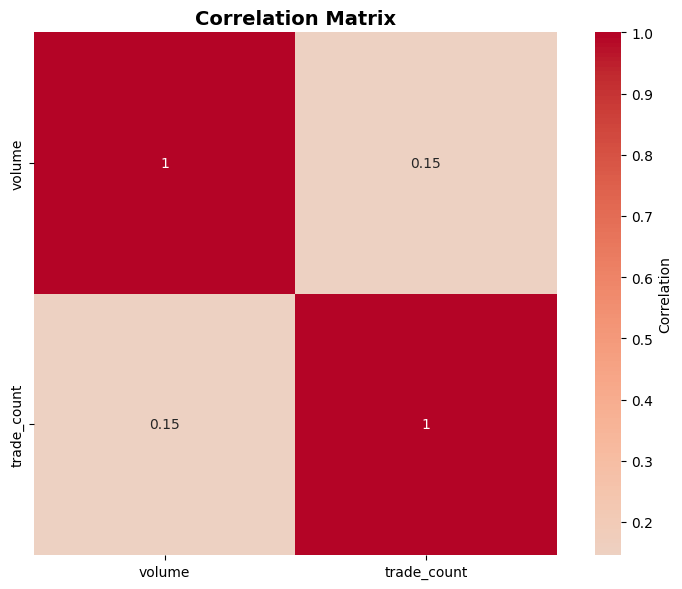

In [14]:
import numpy as np

# Crypto Market Volume Distribution
plt.figure(figsize=(12, 5))
crypto_markets.to_pandas()['volume'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Crypto Market Volumes', fontsize=14, fontweight='bold')
plt.xlabel('Volume (USD)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_summary_pd = df_markets_summary.to_pandas()

# Top 20 High Volume Markets
plt.figure(figsize=(12, 7))
top_markets = df_summary_pd.nlargest(20, 'volume')[['question', 'volume']].sort_values('volume', ascending=True)
plt.barh(range(len(top_markets)), top_markets['volume'].values, color='steelblue')
plt.yticks(range(len(top_markets)), 
          [q[:50] + '...' if len(q) > 50 else q for q in top_markets['question'].values])
plt.xlabel('Volume (USD)', fontsize=12)
plt.title('Top 20 Markets by Volume', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Duration
plt.figure(figsize=(12, 6))
df_summary_pd['duration_days'] = (df_summary_pd['last_trade'] - df_summary_pd['first_trade']).dt.days
plt.hist(df_summary_pd['duration_days'], bins=50, edgecolor='black', color='coral')
plt.xlabel('Trading Duration (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Market Trading Duration', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot: Volume vs Market Count with average volume as size
plt.figure(figsize=(12, 7))

# Calculate average volume per point for sizing
avg_volume_for_size = pd_crypto_daily_volume['daily_volume'].mean()
sizes = (pd_crypto_daily_volume['daily_volume'] / avg_volume_for_size) * 100  # Scale for visibility

plt.scatter(pd_crypto_daily_volume['daily_volume'], pd_crypto_daily_volume['daily_market_count'], 
           s=sizes, alpha=0.6, c=pd_crypto_daily_volume.index, cmap='viridis', edgecolors='black', linewidth=0.5)

plt.xlabel('Daily Volume (USD)', fontsize=12)
plt.ylabel('Daily Market Count', fontsize=12)
plt.title('Daily Volume vs Market Count (Point Size = Avg Volume)', fontsize=14)
plt.colorbar(label='Time Sequence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Volume, Trade Count, Token Count Corr.
import seaborn as sns
plt.figure(figsize=(8, 6))
corr_data = df_summary_pd[['volume', 'trade_count']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True, 
           cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Create join dataframe between crypto_markets and summary by slug(str)

Details  
Sampling market_id = 798778

In [15]:
crypto_markets = crypto_markets.with_columns(
    (pl.col('end_date') - pl.col('created_at'))
    .dt.total_minutes()
    .floor()
    .alias('market_open_duration_minutes')
)
crypto_markets.filter(pl.col('market_id') == "798778")

market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date,market_open_duration_minutes
str,str,str,str,str,f64,bool,bool,datetime[μs],datetime[μs],i64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…","""bitcoin-price-on-december-9""","""Crypto""",8756.369075,true,false,2025-12-02 17:00:02,2025-12-09 17:00:00,10079


In [16]:
# df_markets_summary = df_markets_summary.with_columns(
#     (pl.col("last_trade") - pl.col("first_trade"))
#     .dt.total_minutes()
#     .floor()
#     .alias("actual_market_trade_duration_minutes")
# )

# df_markets_summary.filter(pl.col('market_id')=='798778')


In [17]:
print(f'{crypto_markets.head(1)}\n{df_markets_summary.head(1)}')

shape: (1, 11)
┌───────────┬────────────┬────────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ market_id ┆ question   ┆ slug       ┆ event_slu ┆ … ┆ closed ┆ created_a ┆ end_date  ┆ market_op │
│ ---       ┆ ---        ┆ ---        ┆ g         ┆   ┆ ---    ┆ t         ┆ ---       ┆ en_durati │
│ str       ┆ str        ┆ str        ┆ ---       ┆   ┆ bool   ┆ ---       ┆ datetime[ ┆ on_minute │
│           ┆            ┆            ┆ str       ┆   ┆        ┆ datetime[ ┆ μs]       ┆ s         │
│           ┆            ┆            ┆           ┆   ┆        ┆ μs]       ┆           ┆ ---       │
│           ┆            ┆            ┆           ┆   ┆        ┆           ┆           ┆ i64       │
╞═══════════╪════════════╪════════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ 36        ┆ What will  ┆ what-will- ┆ what-will ┆ … ┆ true   ┆ 2020-10-0 ┆ 2020-11-0 ┆ 46319     │
│           ┆ the price  ┆ the-price- ┆ -the-pric ┆   ┆        ┆ 2         ┆

In [18]:
# df_markets_summary.filter(pl.col('market_id') == "798778")
crypto_markets.filter(pl.col('market_id') == "798778")[0]['slug'][0]

'will-the-price-of-bitcoin-be-between-88000-90000-on-december-9'

Sampling slug = "will-binancecom-become-insolvent-by-feb-28-2023"  

In [19]:
# _slug = "will-binancecom-become-insolvent-by-feb-28-2023"
_slug = "will-the-price-of-bitcoin-be-between-88000-90000-on-december-9"
df_markets_summary.filter(pl.col('slug') == _slug)

market_id,question,slug,volume,active,token_count,trade_count,first_trade,last_trade
str,str,str,f64,bool,i64,i64,datetime[μs],datetime[μs]
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,true,2,279,2025-12-09 04:35:47,2025-12-09 12:51:41


Handle missing value for first_trade and last_trade

In [20]:
joined_crypto_summary = (
    crypto_markets
    .join(
        df_markets_summary,
        on="market_id",
        how="inner",
        suffix="_summary",
    )
    .select(
        [
            "market_id",
            "question",
            "slug",
            "volume",
            "trade_count",
            "created_at",
            "end_date",
            "market_open_duration_minutes",
            "first_trade",
            "last_trade",
            # "actual_market_trade_duration_minutes",
        ]
    )
    .with_columns(        
        pl.when(pl.col("first_trade").is_null())
        .then(pl.col("end_date"))
        .otherwise(pl.col("first_trade"))
        .alias("first_trade"),
        pl.when(pl.col("last_trade").is_null())
        .then(pl.col("end_date"))
        .otherwise(pl.col("last_trade"))
        .alias("last_trade")
    )
    .with_columns( 
        (pl.col("last_trade") - pl.col("first_trade"))
        .dt.total_minutes()
        .floor()
        .alias("actual_market_trade_duration_minutes")
    )
    .with_columns(
        pl.when(
            (pl.col("market_open_duration_minutes").is_null()) |
            (pl.col("market_open_duration_minutes") <= 0)
        )
        .then(pl.lit(0))
        .otherwise(
            (pl.col("actual_market_trade_duration_minutes") /
             pl.col("market_open_duration_minutes"))
            .clip(0.0, 1.0)
        )
        .alias("active_trade_ratio")
            #.fill_null(0)
    )
)

joined_crypto_summary.head()

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0


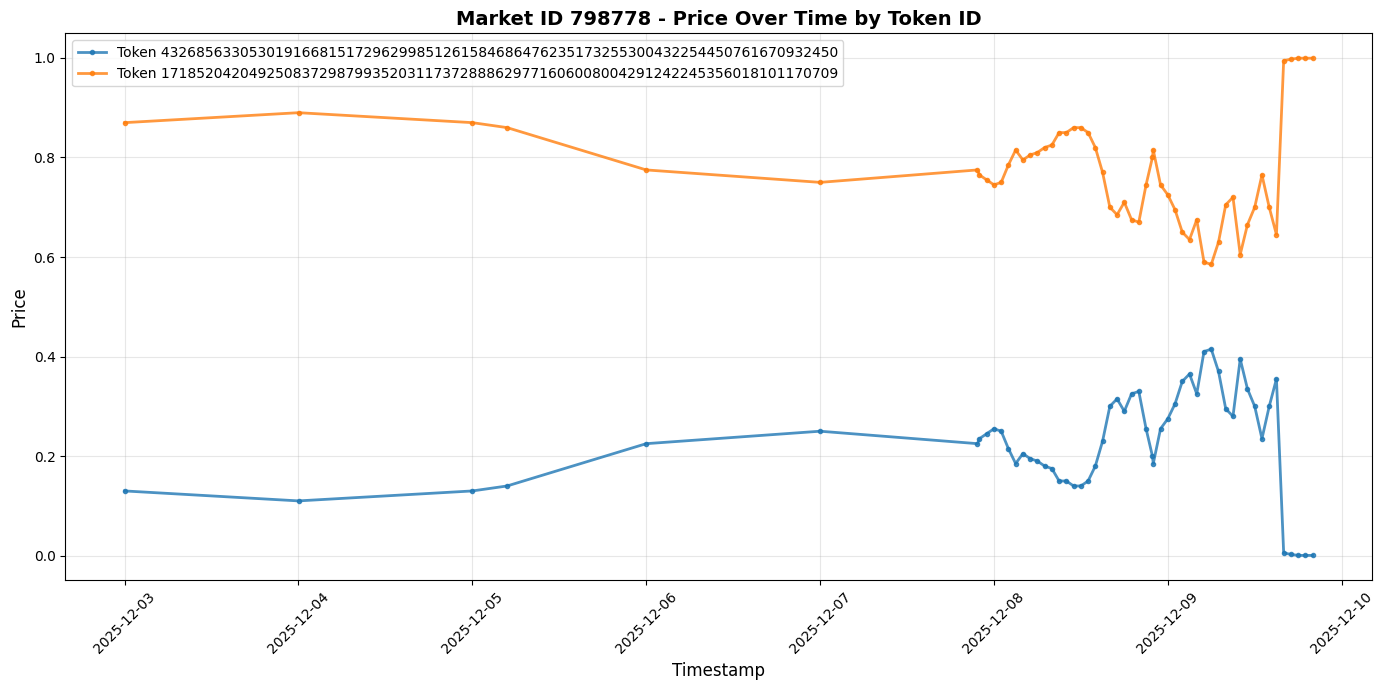


Price Statistics by Token ID:
                                                       price                  \
                                                        mean     min     max   
token_id                                                                       
17185204204925083729879935203117372888629771606...  0.773555  0.5850  0.9995   
43268563305301916681517296299851261584686476235...  0.226445  0.0005  0.4150   

                                                                    
                                                         std count  
token_id                                                            
17185204204925083729879935203117372888629771606...  0.105207    55  
43268563305301916681517296299851261584686476235...  0.105207    55  


In [21]:
import polars as pl
import matplotlib.pyplot as plt

target_market_id = "798778"
market_798778 = (
    df_markets_odds
    .filter(pl.col("market_id") == target_market_id)
    .sort("timestamp")
)
# market_798778
# print(market_798778.columns)
# print(market_798778.to_pandas().groupby('token_id').agg({'price': 'mean'}).columns)
#    .sort_values(by='timestamp').plot(x='timestamp', y='price', title='Market ID 798778 - Yes Price Over Time')

# Convert to pandas for plotting
market_798778_pd = market_798778.to_pandas()

# Plot price over time by token_id
plt.figure(figsize=(14, 7))
for token_id in market_798778_pd['token_id'].unique():
    token_data = market_798778_pd[market_798778_pd['token_id'] == token_id]
    plt.plot(token_data['timestamp'], token_data['price'], 
             marker='o', markersize=3, linewidth=2, label=f'Token {token_id}', alpha=0.8)

plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Market ID 798778 - Price Over Time by Token ID', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Show summary statistics
print("\nPrice Statistics by Token ID:")
print(market_798778_pd.groupby('token_id').agg({
    'price': ['mean', 'min', 'max', 'std', 'count']
}))

In [22]:
df_market_odds_std = df_markets_odds.group_by('market_id').agg(pl.std('price').alias('std_token_price'))
df_market_odds_std

market_id,std_token_price
str,f64
"""806458""",0.0
"""692404""",0.40784
"""615092""",0.0
"""561874""",0.0
"""904042""",0.099045
…,…
"""685454""",0.0
"""902684""",0.301706
"""707268""",0.381635


In [23]:
joined_crypto_summary_std_token_price = joined_crypto_summary.join(
    df_market_odds_std,
    on="market_id",
    how="left",
).with_columns(
    pl.col("std_token_price").fill_null(0)
)
joined_crypto_summary_std_token_price

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105
…,…,…,…,…,…,…,…,…,…,…,…,…
"""697320""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",15985.352289,0,2025-11-22 17:00:11,2025-11-29 17:00:00,10079,2025-11-29 17:00:00,2025-11-29 17:00:00,0,0.0,0.322499
"""240547""","""Will Dharma airdrop a native t…","""will-dharma-airdrop-a-native-t…",10028.65,0,2022-01-11 18:52:51,2022-03-31 00:00:00,112627,2022-03-31 00:00:00,2022-03-31 00:00:00,0,0.0,0.0
"""224954""","""Will it be possible to buy a T…","""will-it-be-possible-to-buy-a-t…",45525.31,0,2021-07-22 19:20:01,2022-01-01 00:00:00,233559,2022-01-01 00:00:00,2022-01-01 00:00:00,0,0.0,0.0


In [24]:
joined_crypto_summary_std_token_price.describe()

statistic,market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price
str,str,str,str,f64,f64,str,str,f64,str,str,f64,f64,f64
"""count""","""27414""","""27414""","""27414""",27414.0,27414.0,"""27414""","""27355""",27355.0,"""27400""","""27400""",27400.0,27414.0,27414.0
"""null_count""","""0""","""0""","""0""",0.0,0.0,"""0""","""59""",59.0,"""14""","""14""",14.0,0.0,0.0
"""mean""",null,null,null,89994.990464,477.530714,"""2025-09-01 12:55:26.759502""","""2025-09-06 11:32:00.239078""",7031.424347,"""2025-09-05 05:07:51.977518""","""2025-09-06 00:03:33.580145""",1135.480511,0.197628,0.132154
"""std""",null,null,null,482676.367577,1258.67326,null,null,34086.995563,null,null,4481.762686,0.313679,0.210756
"""min""","""101490""","""$BITCOIN (HPOS10i) all time hi…","""ageagea-958-915""",0.0,0.0,"""2020-10-02 20:00:04""","""2020-01-01 00:00:00""",-454695.0,"""2020-01-01 00:00:00""","""2020-01-01 00:00:00""",0.0,0.0,0.0
"""25%""",null,null,null,552.578946,0.0,"""2025-09-08 14:00:00""","""2025-09-09 20:00:00""",359.0,"""2025-09-09 08:00:00""","""2025-09-09 16:00:00""",0.0,0.0,0.0
"""50%""",null,null,null,14827.87196,0.0,"""2025-09-25 10:00:01""","""2025-09-26 16:00:00""",1452.0,"""2025-09-26 07:46:03""","""2025-09-26 16:00:00""",0.0,0.0,0.0
"""75%""",null,null,null,66575.62353,260.0,"""2025-11-01 00:46:51""","""2025-11-03 17:00:00""",5708.0,"""2025-11-02 22:05:43""","""2025-11-03 17:00:00""",222.0,0.284354,0.313065
"""max""","""98685""","""[From kain.eth] Will Synthetix…","""xrp-multistrike-4h-1759003200-…",2.8587e7,43097.0,"""2025-12-10 05:32:19""","""2027-01-01 05:00:00""",739550.0,"""2027-01-01 05:00:00""","""2027-01-01 05:00:00""",130962.0,1.0,0.7064


In [25]:
# joined_crypto_summary_std_token_price.to_pandas().plot(x='created_at', y='trade_count', kind='scatter', title='Standard Deviation of Price vs Created Date', figsize=(10, 6))

joined_crypto_summary_std_token_price = joined_crypto_summary_std_token_price.with_columns(
    (
        (pl.col("trade_count") - pl.col("trade_count").min())
        / (pl.col("trade_count").max() - pl.col("trade_count").min())
    ).alias("trade_count_norm")
)

# joined_crypto_summary_std_token_price = joined_crypto_summary_std_token_price.with_columns(
#     pl.log1p("trade_count").alias("trade_count_log")
# ).with_columns(
#     (
#         (pl.col("trade_count_log") - pl.col("trade_count_log").min())
#         / (pl.col("trade_count_log").max() - pl.col("trade_count_log").min())
#     ).alias("trade_count_log_norm")
# )

joined_crypto_summary_std_token_price

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084,0.006474
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799,0.157668
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366,0.000093
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101,0.027334
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105,0.000023
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""697320""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",15985.352289,0,2025-11-22 17:00:11,2025-11-29 17:00:00,10079,2025-11-29 17:00:00,2025-11-29 17:00:00,0,0.0,0.322499,0.0
"""240547""","""Will Dharma airdrop a native t…","""will-dharma-airdrop-a-native-t…",10028.65,0,2022-01-11 18:52:51,2022-03-31 00:00:00,112627,2022-03-31 00:00:00,2022-03-31 00:00:00,0,0.0,0.0,0.0
"""224954""","""Will it be possible to buy a T…","""will-it-be-possible-to-buy-a-t…",45525.31,0,2021-07-22 19:20:01,2022-01-01 00:00:00,233559,2022-01-01 00:00:00,2022-01-01 00:00:00,0,0.0,0.0,0.0


<Axes: title={'center': '(BTC) Active trade ratio vs Standard Deviation of Price'}, xlabel='active_trade_ratio', ylabel='std_token_price'>

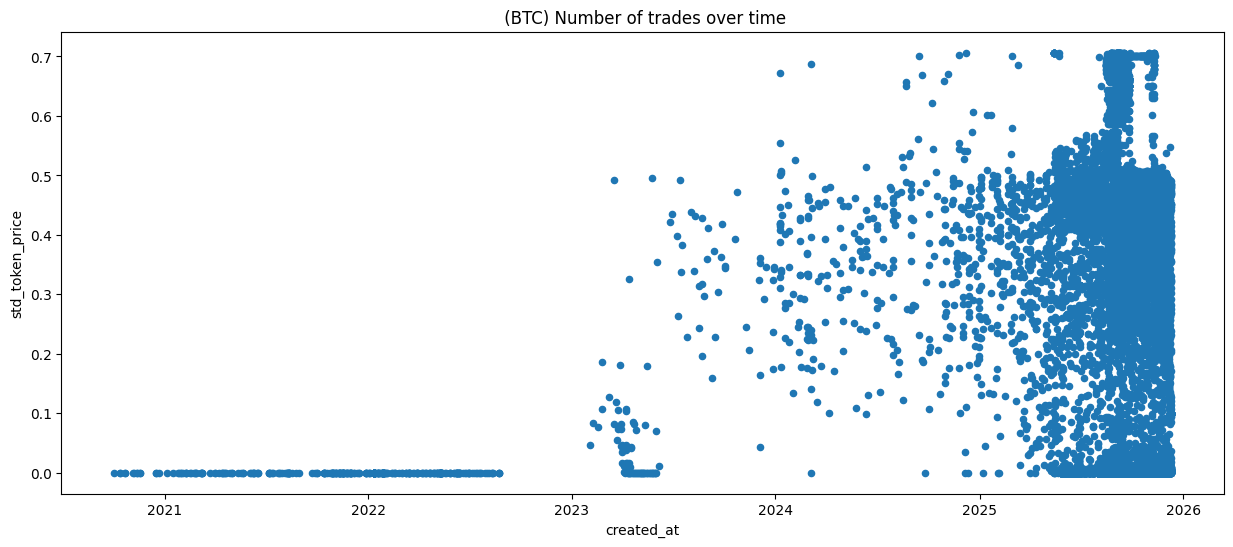

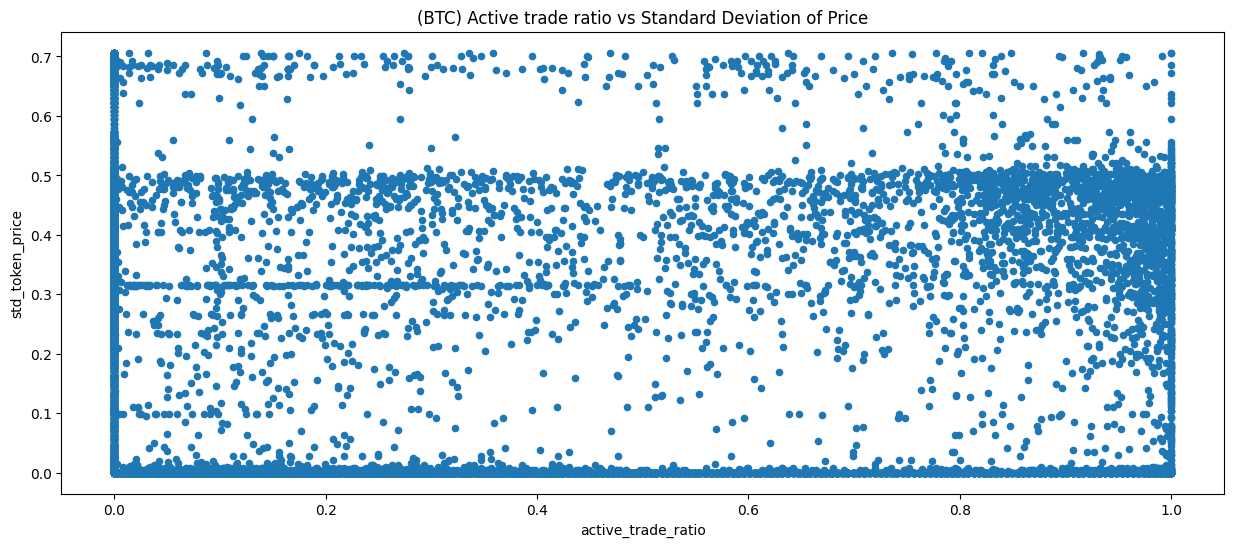

In [26]:
joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(
        x='created_at', y='std_token_price', kind='scatter', title=' (BTC) Number of trades over time', figsize=(15, 6))

joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(x='active_trade_ratio', y='std_token_price', kind='scatter', 
                       title='(BTC) Active trade ratio vs Standard Deviation of Price', figsize=(15, 6))


In [27]:
print(joined_crypto_summary_std_token_price.select(['created_at']).min(),
      joined_crypto_summary_std_token_price.select(['created_at']).max())

shape: (1, 1)
┌─────────────────────┐
│ created_at          │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-10-02 20:00:04 │
└─────────────────────┘ shape: (1, 1)
┌─────────────────────┐
│ created_at          │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2025-12-10 05:32:19 │
└─────────────────────┘


<Axes: title={'center': 'Number of trades over time'}>

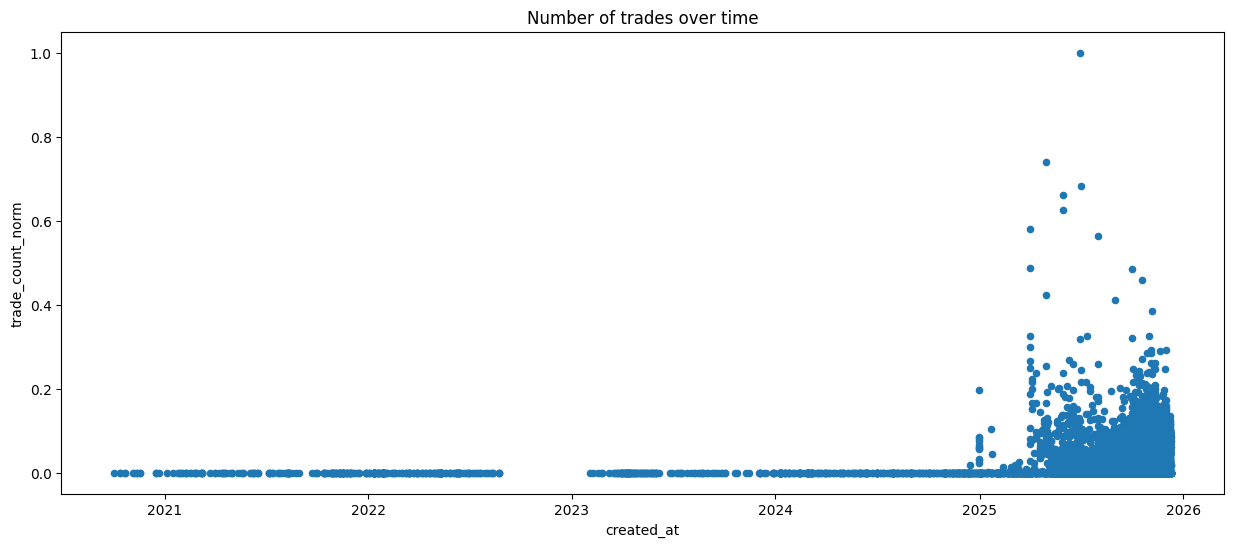

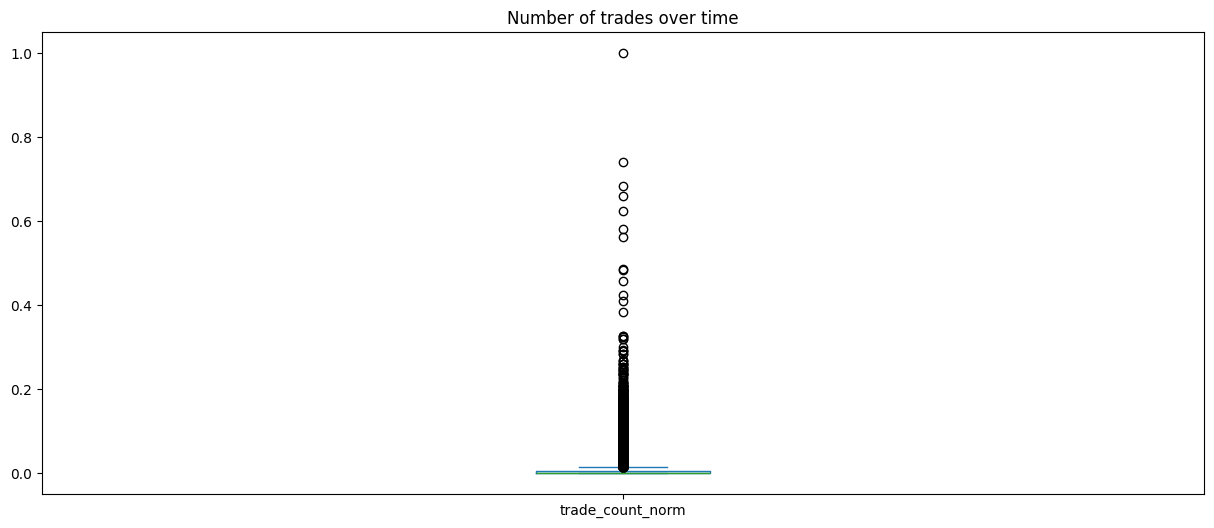

In [28]:
joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(
        x='created_at', y='trade_count_norm', kind='scatter', title='Number of trades over time', figsize=(15, 6))

joined_crypto_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(x='active_trade_ratio', y='trade_count_norm', kind='box', title='Number of trades over time', figsize=(15, 6))


In [29]:
joined_crypto_summary_std_token_price.filter(pl.col('created_at')<pl.datetime(2020,10,31,0,0,0))

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64,f64
"""63""","""Will BTC break $15k before 202…","""will-btc-break-15k-before-2021…",224706.49,0,2020-10-22 16:50:03,2021-01-01 00:00:00,101229,2021-01-01 00:00:00,2021-01-01 00:00:00,0,0.0,0.0,0.0
"""44""","""What will the USD price of Fil…","""what-will-the-usd-price-of-fil…",69947.1,0,2020-10-12 22:00:05,2020-11-17 00:00:00,50519,2020-11-17 00:00:00,2020-11-17 00:00:00,0,0.0,0.0,0.0
"""43""","""What will the total value lock…","""what-will-the-total-value-lock…",46944.58,0,2020-10-12 22:00:05,2021-01-02 00:00:00,116759,2021-01-02 00:00:00,2021-01-02 00:00:00,0,0.0,0.0,0.0
"""36""","""What will the price of Bitcoin…","""what-will-the-price-of-bitcoin…",59755.8,0,2020-10-02 20:00:04,2020-11-04 00:00:00,46319,2020-11-04 00:00:00,2020-11-04 00:00:00,0,0.0,0.0,0.0
"""57""","""Will Dharma’s Phase 1 Retroact…","""will-dharma-s-phase-1-retroact…",35661.94,0,2020-10-21 21:00:05,2020-10-31 00:00:00,13139,2020-10-31 00:00:00,2020-10-31 00:00:00,0,0.0,0.0,0.0


In [30]:
# joined_crypto_summary_stdprice
# joined_crypto_summary_std_token_price_filtered = joined_crypto_summary_std_token_price.filter(pl.col('first_trade').is_not_null())
joined_crypto_summary_std_token_price_filtered = joined_crypto_summary_std_token_price
print(joined_crypto_summary_std_token_price_filtered.select(['created_at']).min(),
      joined_crypto_summary_std_token_price_filtered.select(['created_at']).max())

shape: (1, 1)
┌─────────────────────┐
│ created_at          │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2020-10-02 20:00:04 │
└─────────────────────┘ shape: (1, 1)
┌─────────────────────┐
│ created_at          │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2025-12-10 05:32:19 │
└─────────────────────┘


Maket strength index 



In [31]:
joined_crypto_summary_std_token_price_filtered.columns

['market_id',
 'question',
 'slug',
 'volume',
 'trade_count',
 'created_at',
 'end_date',
 'market_open_duration_minutes',
 'first_trade',
 'last_trade',
 'actual_market_trade_duration_minutes',
 'active_trade_ratio',
 'std_token_price',
 'trade_count_norm']

In [32]:
import polars as pl

def add_crypto_poly_index(
    df: pl.DataFrame,
    weights: dict | None = None,
) -> pl.DataFrame:
    if weights is None:
        weights = {
            "trade_count": 0.3,
            "volume": 0.3,
            "std_token_price": 0.2,
            "active_trade_ratio": 0.2,
        }

    def minmax(col: str) -> pl.Expr:
        c = pl.col(col)
        c_min = c.min()
        c_max = c.max()
        return (
            pl.when(c_max == c_min)
            .then(pl.lit(0.0))
            .otherwise((c - c_min) / (c_max - c_min))
        )

    df = df.with_columns(
        [
            pl.col("trade_count").log1p().alias("trade_count_log"),
            pl.col("volume").log1p().alias("volume_log"),
            pl.col("std_token_price").log1p().alias("std_token_price_log"),
        ]
    ).with_columns(
        [
            minmax("trade_count_log").alias("trade_count_norm"),
            minmax("volume_log").alias("volume_norm"),
            minmax("std_token_price_log").alias("std_token_price_norm"),
            minmax("active_trade_ratio").alias("active_trade_ratio_norm"),
        ]
    ).with_columns(
        (
            pl.col("trade_count_norm") * weights["trade_count"]
            + pl.col("volume_norm") * weights["volume"]
            + pl.col("std_token_price_norm") * weights["std_token_price"]
            + pl.col("active_trade_ratio_norm") * weights["active_trade_ratio"]
        )
        .clip(0.0, 1.0)
        .alias("crypto_poly_index")
    )

    return df

joined_crypto_summary_stdprice_index = add_crypto_poly_index(
    joined_crypto_summary_std_token_price_filtered,
    weights={"trade_count": 0.35, "volume": 0.35, "std_token_price": 0.01, "active_trade_ratio": 0.29},
)

# fill missing 

# fill null with 0 for index
joined_crypto_summary_stdprice_index = joined_crypto_summary_stdprice_index.with_columns(
    pl.col("crypto_poly_index").fill_null(0)
)

joined_crypto_summary_stdprice_index

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm,trade_count_log,volume_log,std_token_price_log,volume_norm,std_token_price_norm,active_trade_ratio_norm,crypto_poly_index
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,279,2025-12-02 17:00:02,2025-12-09 17:00:00,10079,2025-12-09 04:35:47,2025-12-09 12:51:41,495,0.049112,0.294084,0.528036,5.63479,9.077651,0.257803,0.528739,0.482429,0.049112,0.388938
"""687200""","""Will Bitcoin reach $100,000 by…","""will-bitcoin-reach-100000-by-d…",3.0088e6,6795,2025-11-17 16:10:33,2026-01-01 05:00:00,64129,2025-11-26 11:11:15,2026-01-01 05:26:25,51495,0.802991,0.296799,0.826904,8.824089,14.917048,0.259899,0.868863,0.486352,0.802991,0.831249
"""865705""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",0.0,4,2025-12-06 17:00:07,2025-12-13 17:00:00,10079,2025-12-08 12:30:31,2025-12-08 15:22:51,172,0.017065,0.472366,0.15082,1.609438,0.0,0.38687,0.0,0.723954,0.017065,0.064976
"""894893""","""Bitcoin Up or Down - December …","""btc-updown-15m-1765282500""",3.920783,1178,2025-12-08 12:17:21,2025-12-09 12:30:00,1452,2025-12-08 12:37:29,2025-12-09 12:30:23,1432,0.986226,0.00101,0.662756,7.072422,1.593468,0.00101,0.092814,0.001889,0.986226,0.550474
"""834874""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",21.978011,1,2025-12-05 17:00:02,2025-12-12 17:00:00,10079,2025-12-07 17:12:25,2025-12-07 17:12:25,0,0.0,0.419105,0.064955,0.693147,3.134538,0.350026,0.182575,0.655007,0.0,0.093186
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""697320""","""Will the price of XRP be betwe…","""will-the-price-of-xrp-be-betwe…",15985.352289,0,2025-11-22 17:00:11,2025-11-29 17:00:00,10079,2025-11-29 17:00:00,2025-11-29 17:00:00,0,0.0,0.322499,0.0,0.0,9.679491,0.279523,0.563794,0.523073,0.0,0.202559
"""240547""","""Will Dharma airdrop a native t…","""will-dharma-airdrop-a-native-t…",10028.65,0,2022-01-11 18:52:51,2022-03-31 00:00:00,112627,2022-03-31 00:00:00,2022-03-31 00:00:00,0,0.0,0.0,0.0,0.0,9.213301,0.0,0.536641,0.0,0.0,0.187824
"""224954""","""Will it be possible to buy a T…","""will-it-be-possible-to-buy-a-t…",45525.31,0,2021-07-22 19:20:01,2022-01-01 00:00:00,233559,2022-01-01 00:00:00,2022-01-01 00:00:00,0,0.0,0.0,0.0,0.0,10.726046,0.0,0.624752,0.0,0.0,0.218663


In [33]:
joined_crypto_summary_stdprice_index.write_parquet(PROJECT_ROOT / "data" / "joined_crypto_summary_std_token_price_index.parquet")
# joined_crypto_summary_stdprice_index


<Axes: title={'center': 'Crypto Poly Index over Time'}, xlabel='created_at', ylabel='crypto_poly_index'>

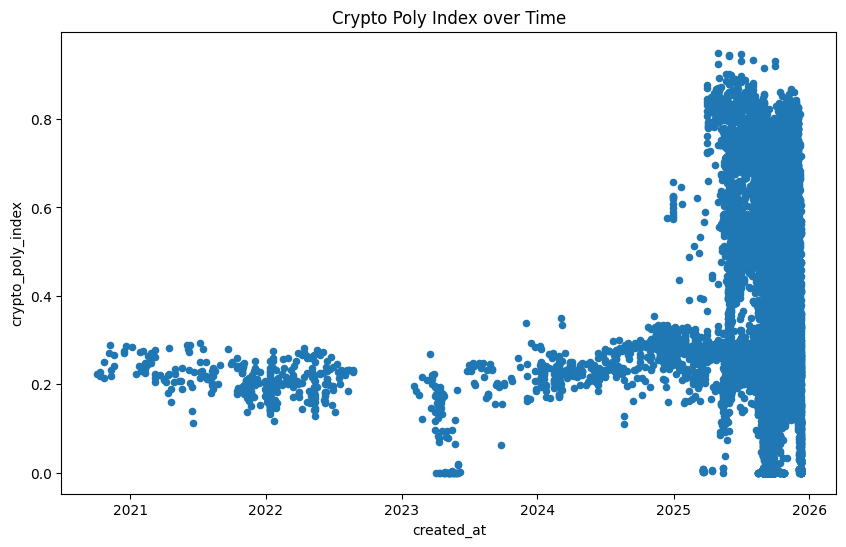

In [34]:
joined_crypto_summary_stdprice_index.to_pandas().\
    plot(x='created_at', y='crypto_poly_index', kind='scatter', title='Crypto Poly Index over Time', figsize=(10, 6))

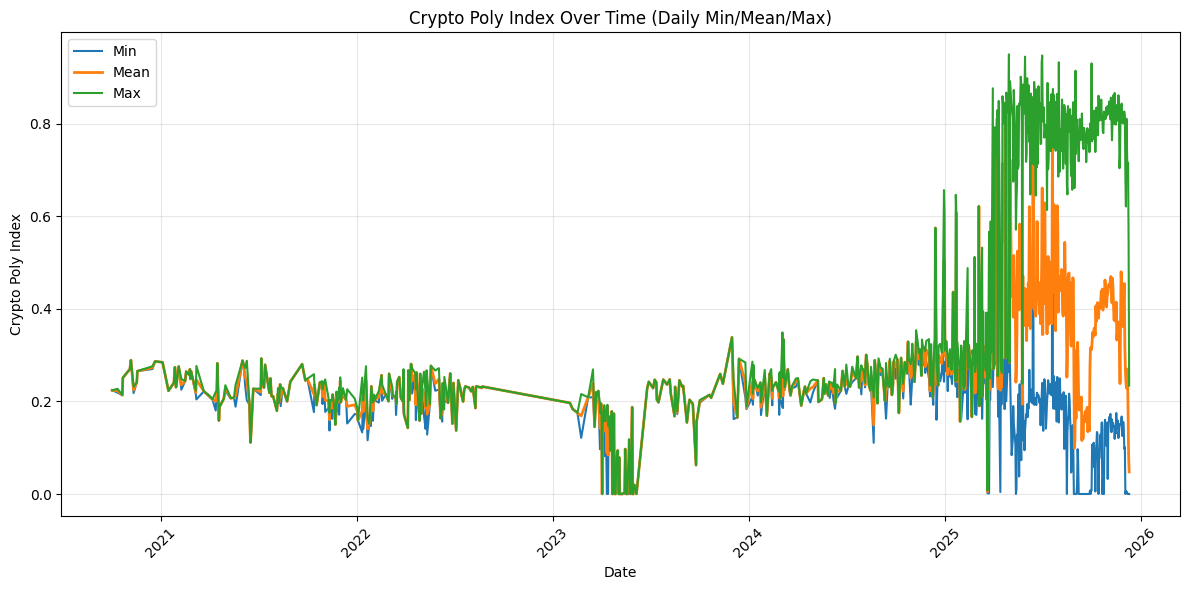

In [35]:
import matplotlib.pyplot as plt

df_poly_idx = joined_crypto_summary_stdprice_index.to_pandas()

daily = (
    df_poly_idx.dropna(subset=["created_at", "crypto_poly_index"])
          .assign(date=df_poly_idx["created_at"].dt.date)
          .groupby("date")["crypto_poly_index"]
          .agg(["min", "mean", "max"])
          .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(daily["date"], daily["min"], label="Min", linewidth=1.5)
plt.plot(daily["date"], daily["mean"], label="Mean", linewidth=2)
plt.plot(daily["date"], daily["max"], label="Max", linewidth=1.5)
plt.title("Crypto Poly Index Over Time (Daily Min/Mean/Max)")
plt.xlabel("Date")
plt.ylabel("Crypto Poly Index")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
# Same the poly index with min-max normalization applied to trade_count and volume, but without log transformation, to see if it changes the distribution significantly.
joined_crypto_summary_stdprice_index.write_parquet(PROJECT_ROOT / "data" / "joined_crypto_summary_std_token_price_index.parquet")

Trump

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

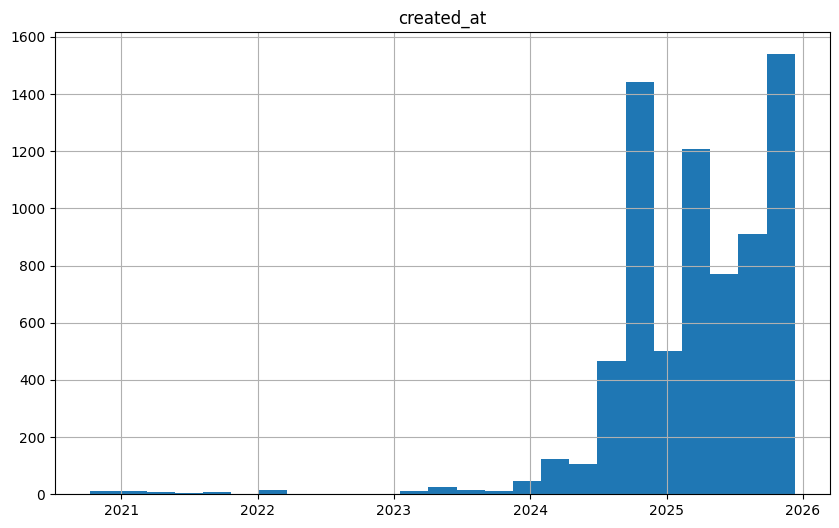

In [37]:
trump_markets = df_markets.filter(pl.col('category') == 'Trump').sort('created_at', descending=False)  
trump_markets.to_pandas().hist(column='created_at', bins=25, figsize=(10, 6))

In [38]:
trump_markets

market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date
str,str,str,str,str,f64,bool,bool,datetime[μs],datetime[μs]
"""40""","""Will Trump win the 2020 U.S. p…","""will-trump-win-the-2020-us-pre…","""will-trump-win-the-2020-us-pre…","""Trump""",1.0803e7,true,true,2020-10-09 17:00:08,2020-11-20 00:00:00
"""73""","""Will Donald Trump tweet announ…","""will-donald-trump-tweet-announ…","""will-donald-trump-tweet-announ…","""Trump""",127490.67,true,true,2020-10-30 15:45:08,2020-11-05 00:00:00
"""77""","""Will Donald Trump formally con…","""will-donald-trump-formally-con…","""will-donald-trump-formally-con…","""Trump""",454342.99,true,true,2020-11-06 23:05:12,2020-12-01 00:00:00
"""87""","""Will Donald Trump attend Joe B…","""will-donald-trump-attend-joe-b…","""will-donald-trump-attend-joe-b…","""Trump""",192840.87,true,true,2020-11-07 21:05:04,2021-02-01 00:00:00
"""93""","""Will Donald Trump be inaugurat…","""will-donald-trump-be-inaugurat…","""will-donald-trump-be-inaugurat…","""Trump""",3.0208e7,true,true,2020-11-08 19:50:06,2021-02-01 00:00:00
…,…,…,…,…,…,…,…,…,…
"""898160""","""Will Donald Trump announce a n…","""will-donald-trump-announce-a-n…","""trump-announces-fed-chair-nomi…","""Trump""",20.0,true,false,2025-12-08 21:44:19,2026-01-31 00:00:00
"""898161""","""Trump cabinet member out by Ju…","""trump-cabinet-member-out-by-ju…","""trump-cabinet-member-out-by""","""Trump""",0.0,true,false,2025-12-08 21:44:50,2026-06-30 12:00:00
"""898162""","""Will Donald Trump announce a n…","""will-donald-trump-announce-a-n…","""trump-announces-fed-chair-nomi…","""Trump""",20.0,true,false,2025-12-08 21:45:12,2026-01-31 00:00:00


In [39]:
# Largest volume sample 10 questions from crypto markets
sampled_trump_questions = trump_markets.select(['question', 'created_at', 'category','volume']).sort('volume', descending=True).head(20)
print("Random 20 Trump Market Questions:")
print("=" * 80)
for idx, row in enumerate(sampled_trump_questions.to_pandas().itertuples(), 1):
    q = f"{row.question} ({row.category})"
    print(f"{idx:02d}. [{row.created_at.strftime('%Y-%m-%d')}] {q:<125}{row.volume:>15,.1f}")

Random 20 Trump Market Questions:
01. [2024-01-04] Will Donald Trump win the 2024 US Presidential Election? (Trump)                                                             1,531,479,284.5
02. [2024-11-01] Will Donald Trump be inaugurated? (Trump)                                                                                      400,409,526.9
03. [2024-01-09] Will Donald Trump win the popular vote in the 2024 Presidential Election? (Trump)                                              119,932,620.8
04. [2024-06-17] Will Trump launch a coin before the election? (Trump)                                                                           76,899,060.6
05. [2024-10-21] Trump ends Ukraine war in first 90 days? (Trump)                                                                                56,491,984.3
06. [2020-11-08] Will Donald Trump be inaugurated for his second term as President of the USA on Inauguration Day, January 20th, 2021? (Trump)   30,207,577.4
07. [2024-12-31] W

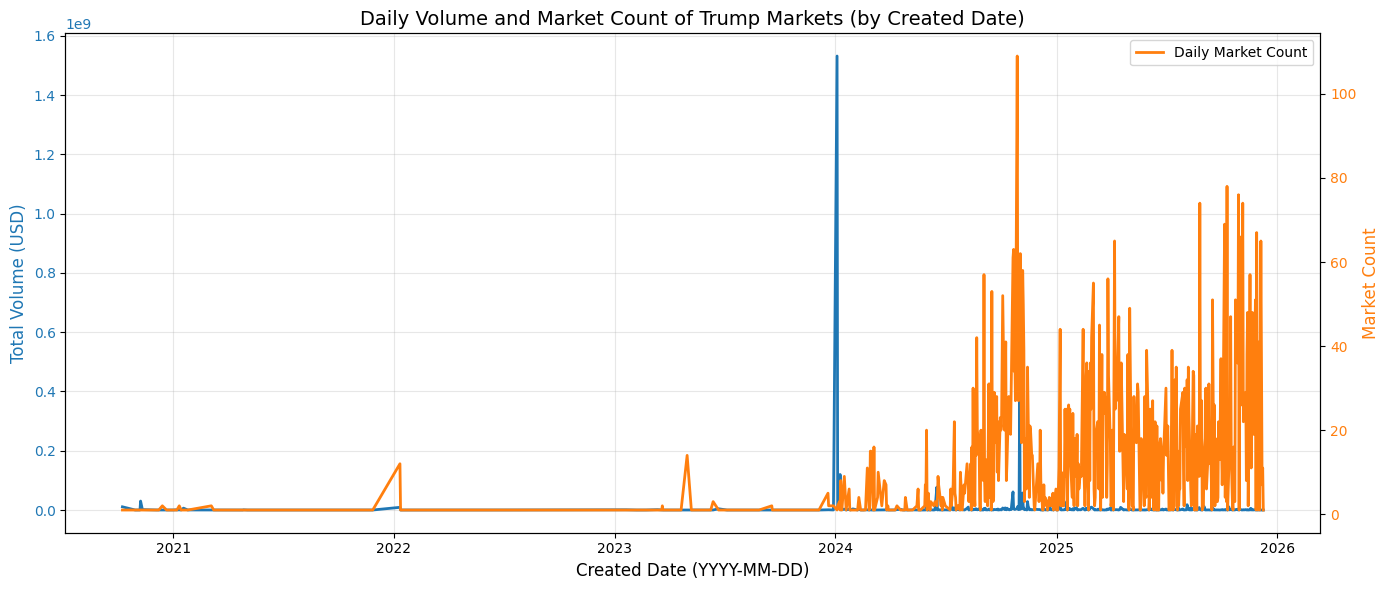

In [40]:
# Group Trump markets by created_at date and sum volume
trump_daily_volume = (
    trump_markets
    .with_columns(pl.col('created_at').cast(pl.Date).alias('date'))
    .group_by('date')
    .agg(pl.col('volume').sum().alias('daily_volume'), pl.col('market_id').count().alias('daily_market_count'))
    .sort('date')
)

# Plot with dual y-axis
plt.figure(figsize=(14, 6))
pd_trump_daily_volume = trump_daily_volume.to_pandas()

ax1 = plt.gca()
ax1.plot(pd_trump_daily_volume['date'], pd_trump_daily_volume['daily_volume'], color='tab:blue', linewidth=2, label='Daily Volume')
ax1.set_xlabel('Created Date (YYYY-MM-DD)', fontsize=12)
ax1.set_ylabel('Total Volume (USD)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(pd_trump_daily_volume['date'], pd_trump_daily_volume['daily_market_count'], 
         color='tab:orange', linewidth=2, label='Daily Market Count')
ax2.set_ylabel('Market Count', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Daily Volume and Market Count of Trump Markets (by Created Date)', fontsize=14)
plt.legend()
ax1.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.tight_layout()
plt.show()

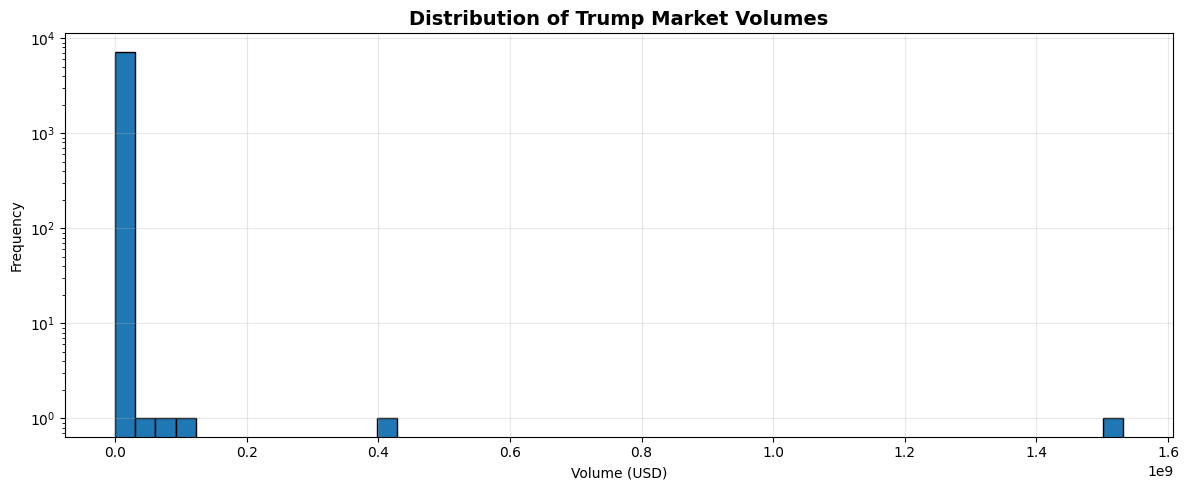

In [41]:
import numpy as np

# Crypto Market Volume Distribution
plt.figure(figsize=(12, 5))
trump_markets.to_pandas()['volume'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Trump Market Volumes', fontsize=14, fontweight='bold')
plt.xlabel('Volume (USD)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [42]:
trump_markets = trump_markets.with_columns(
    (pl.col('end_date') - pl.col('created_at'))
    .dt.total_minutes()
    .floor()
    .alias('market_open_duration_minutes')
)

In [43]:

joined_trump_summary = (
    trump_markets
    .join(
        df_markets_summary,
        on="market_id",
        how="inner",
        suffix="_summary",
    )
    .select(
        [
            "market_id",
            "question",
            "slug",
            "volume",
            "trade_count",
            "created_at",
            "end_date",
            "market_open_duration_minutes",
            "first_trade",
            "last_trade",
            # "actual_market_trade_duration_minutes",
        ]
    )
    .with_columns(        
        pl.when(pl.col("first_trade").is_null())
        .then(pl.col("end_date"))
        .otherwise(pl.col("first_trade"))
        .alias("first_trade"),
        pl.when(pl.col("last_trade").is_null())
        .then(pl.col("end_date"))
        .otherwise(pl.col("last_trade"))
        .alias("last_trade"))
    .with_columns( 
        (pl.col("last_trade") - pl.col("first_trade"))
        .dt.total_minutes()
        .floor()
        .alias("actual_market_trade_duration_minutes")
    )
    .with_columns(
        pl.when(
            (pl.col("market_open_duration_minutes").is_null()) |
            (pl.col("market_open_duration_minutes") <= 0)
        )
        .then(pl.lit(0))
        .otherwise(
            (pl.col("actual_market_trade_duration_minutes") /
             pl.col("market_open_duration_minutes"))
            .clip(0.0, 1.0)
        )
        .alias("active_trade_ratio")
            #.fill_null(0)
    )
)

joined_trump_summary.head()
joined_trump_summary = joined_trump_summary.drop_nulls(subset=["created_at", "end_date"])
joined_trump_summary

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64
"""734893""","""Will Donald Trump visit Oregon…","""will-donald-trump-visit-oregon…",175.702266,9,2025-11-28 16:19:29,2026-12-31 00:00:00,572140,2025-12-01 22:25:06,2025-12-06 05:44:31,6199,0.010835
"""537698""","""Will Trump lower tariffs on Ca…","""will-trump-lower-tariffs-on-ca…",51182.277796,57,2025-04-16 21:16:36,2025-07-31 12:00:00,152083,2025-11-27 03:57:37,2026-01-01 12:13:15,50895,0.334653
"""549607""","""Will Trump pardon Elizabeth Ho…","""will-trump-pardon-elizabeth-ho…",147980.476057,169,2025-06-03 19:30:28,2025-12-31 12:00:00,303389,2025-11-26 11:36:33,2026-01-01 00:51:49,51195,0.168744
"""645017""","""Trump imposes tariff on semico…","""trump-imposes-tariff-on-semico…",5143.980596,63,2025-10-22 20:32:15,2025-12-31 00:00:00,99567,2025-11-27 10:44:07,2026-01-01 04:10:05,50005,0.502225
"""572476""","""Will Trump nominate Arthur Laf…","""will-trump-nominate-arthur-laf…",482213.105304,128,2025-08-05 17:13:22,2026-12-31 00:00:00,737686,2025-11-28 07:24:57,2026-01-05 05:58:31,54633,0.07406
…,…,…,…,…,…,…,…,…,…,…,…
"""798198""","""Will Trump say ""Steve"" or ""Wit…","""will-trump-say-steve-or-witkof…",2083.292628,0,2025-12-02 15:35:59,2025-12-04 00:00:00,1944,2025-12-04 00:00:00,2025-12-04 00:00:00,0,0.0
"""255182""","""Trump margin of victory in Ida…","""trump-margin-of-victory-in-ida…",200.0,0,2024-03-01 19:37:55,2024-02-29 00:00:00,-2617,2024-02-29 00:00:00,2024-02-29 00:00:00,0,0.0
"""512195""","""Will Trump nominate John Ratcl…","""will-trump-nominate-john-ratcl…",27727.104156,0,2024-11-06 19:09:55,2025-06-30 12:00:00,339410,2025-06-30 12:00:00,2025-06-30 12:00:00,0,0.0


In [44]:
joined_trump_summary_std_token_price = joined_trump_summary.join(
    df_market_odds_std,
    on="market_id",
    how="left",
).with_columns(
    pl.col("std_token_price").fill_null(0)
)
joined_trump_summary_std_token_price

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64
"""734893""","""Will Donald Trump visit Oregon…","""will-donald-trump-visit-oregon…",175.702266,9,2025-11-28 16:19:29,2026-12-31 00:00:00,572140,2025-12-01 22:25:06,2025-12-06 05:44:31,6199,0.010835,0.03298
"""537698""","""Will Trump lower tariffs on Ca…","""will-trump-lower-tariffs-on-ca…",51182.277796,57,2025-04-16 21:16:36,2025-07-31 12:00:00,152083,2025-11-27 03:57:37,2026-01-01 12:13:15,50895,0.334653,0.29268
"""549607""","""Will Trump pardon Elizabeth Ho…","""will-trump-pardon-elizabeth-ho…",147980.476057,169,2025-06-03 19:30:28,2025-12-31 12:00:00,303389,2025-11-26 11:36:33,2026-01-01 00:51:49,51195,0.168744,0.452577
"""645017""","""Trump imposes tariff on semico…","""trump-imposes-tariff-on-semico…",5143.980596,63,2025-10-22 20:32:15,2025-12-31 00:00:00,99567,2025-11-27 10:44:07,2026-01-01 04:10:05,50005,0.502225,0.366812
"""572476""","""Will Trump nominate Arthur Laf…","""will-trump-nominate-arthur-laf…",482213.105304,128,2025-08-05 17:13:22,2026-12-31 00:00:00,737686,2025-11-28 07:24:57,2026-01-05 05:58:31,54633,0.07406,0.499365
…,…,…,…,…,…,…,…,…,…,…,…,…
"""798198""","""Will Trump say ""Steve"" or ""Wit…","""will-trump-say-steve-or-witkof…",2083.292628,0,2025-12-02 15:35:59,2025-12-04 00:00:00,1944,2025-12-04 00:00:00,2025-12-04 00:00:00,0,0.0,0.367263
"""255182""","""Trump margin of victory in Ida…","""trump-margin-of-victory-in-ida…",200.0,0,2024-03-01 19:37:55,2024-02-29 00:00:00,-2617,2024-02-29 00:00:00,2024-02-29 00:00:00,0,0.0,0.141421
"""512195""","""Will Trump nominate John Ratcl…","""will-trump-nominate-john-ratcl…",27727.104156,0,2024-11-06 19:09:55,2025-06-30 12:00:00,339410,2025-06-30 12:00:00,2025-06-30 12:00:00,0,0.0,0.382017


In [45]:
# joined_crypto_summary_std_token_price.to_pandas().plot(x='created_at', y='trade_count', kind='scatter', title='Standard Deviation of Price vs Created Date', figsize=(10, 6))

joined_trump_summary_std_token_price = joined_trump_summary_std_token_price.with_columns(
    (
        (pl.col("trade_count") - pl.col("trade_count").min())
        / (pl.col("trade_count").max() - pl.col("trade_count").min())
    ).alias("trade_count_norm")
)

joined_trump_summary_std_token_price

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64,f64
"""734893""","""Will Donald Trump visit Oregon…","""will-donald-trump-visit-oregon…",175.702266,9,2025-11-28 16:19:29,2026-12-31 00:00:00,572140,2025-12-01 22:25:06,2025-12-06 05:44:31,6199,0.010835,0.03298,0.000163
"""537698""","""Will Trump lower tariffs on Ca…","""will-trump-lower-tariffs-on-ca…",51182.277796,57,2025-04-16 21:16:36,2025-07-31 12:00:00,152083,2025-11-27 03:57:37,2026-01-01 12:13:15,50895,0.334653,0.29268,0.001034
"""549607""","""Will Trump pardon Elizabeth Ho…","""will-trump-pardon-elizabeth-ho…",147980.476057,169,2025-06-03 19:30:28,2025-12-31 12:00:00,303389,2025-11-26 11:36:33,2026-01-01 00:51:49,51195,0.168744,0.452577,0.003065
"""645017""","""Trump imposes tariff on semico…","""trump-imposes-tariff-on-semico…",5143.980596,63,2025-10-22 20:32:15,2025-12-31 00:00:00,99567,2025-11-27 10:44:07,2026-01-01 04:10:05,50005,0.502225,0.366812,0.001143
"""572476""","""Will Trump nominate Arthur Laf…","""will-trump-nominate-arthur-laf…",482213.105304,128,2025-08-05 17:13:22,2026-12-31 00:00:00,737686,2025-11-28 07:24:57,2026-01-05 05:58:31,54633,0.07406,0.499365,0.002321
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""798198""","""Will Trump say ""Steve"" or ""Wit…","""will-trump-say-steve-or-witkof…",2083.292628,0,2025-12-02 15:35:59,2025-12-04 00:00:00,1944,2025-12-04 00:00:00,2025-12-04 00:00:00,0,0.0,0.367263,0.0
"""255182""","""Trump margin of victory in Ida…","""trump-margin-of-victory-in-ida…",200.0,0,2024-03-01 19:37:55,2024-02-29 00:00:00,-2617,2024-02-29 00:00:00,2024-02-29 00:00:00,0,0.0,0.141421,0.0
"""512195""","""Will Trump nominate John Ratcl…","""will-trump-nominate-john-ratcl…",27727.104156,0,2024-11-06 19:09:55,2025-06-30 12:00:00,339410,2025-06-30 12:00:00,2025-06-30 12:00:00,0,0.0,0.382017,0.0


<Axes: title={'center': '(Trump) Active trade ratio vs Standard Deviation of Price'}>

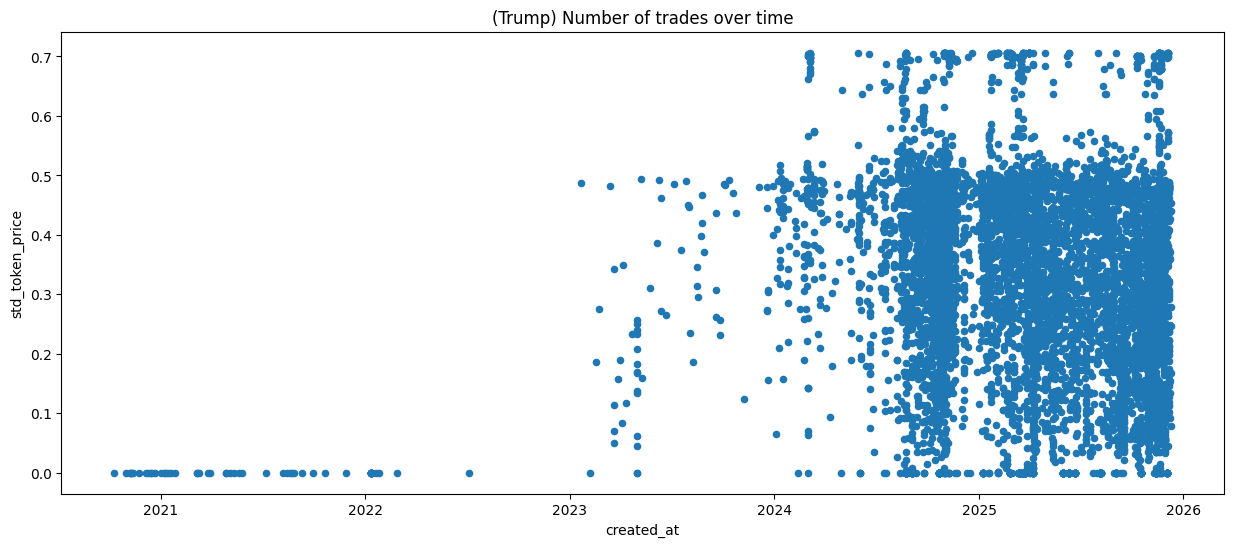

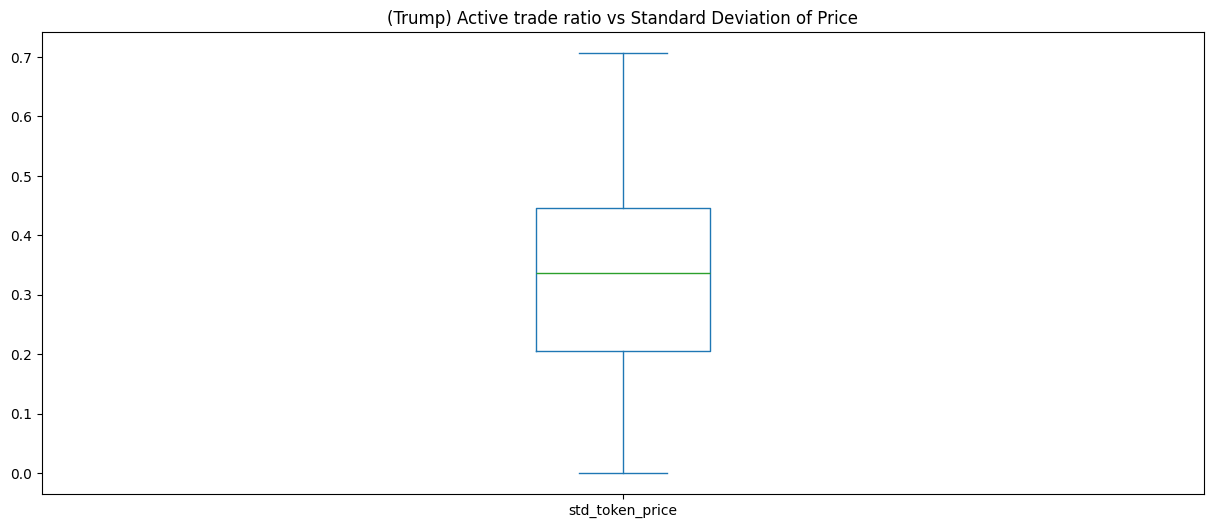

In [46]:
joined_trump_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(
        x='created_at', y='std_token_price', kind='scatter', title='(Trump) Number of trades over time', figsize=(15, 6))

joined_trump_summary_std_token_price.filter(
    pl.col('first_trade').is_not_null()
    ).to_pandas().plot(x='active_trade_ratio', y='std_token_price', kind='box', 
                       title='(Trump) Active trade ratio vs Standard Deviation of Price', figsize=(15, 6))


In [47]:
import polars as pl

def add_trump_poly_index(
    df: pl.DataFrame,
    weights: dict | None = None,
) -> pl.DataFrame:
    if weights is None:
        weights = {
            "trade_count": 0.3,
            "volume": 0.3,
            "std_token_price": 0.2,
            "active_trade_ratio": 0.2,
        }

    def minmax(col: str) -> pl.Expr:
        c = pl.col(col)
        c_min = c.min()
        c_max = c.max()
        return (
            pl.when(c_max == c_min)
            .then(pl.lit(0.0))
            .otherwise((c - c_min) / (c_max - c_min))
        )

    df = df.with_columns(
        [
            pl.col("trade_count").log1p().alias("trade_count_log"),
            pl.col("volume").log1p().alias("volume_log"),
            pl.col("std_token_price").log1p().alias("std_token_price_log"),
        ]
    ).with_columns(
        [
            minmax("trade_count_log").alias("trade_count_norm"),
            minmax("volume_log").alias("volume_norm"),
            minmax("std_token_price_log").alias("std_token_price_norm"),
            minmax("active_trade_ratio").alias("active_trade_ratio_norm"),
        ]
    ).with_columns(
        (
            pl.col("trade_count_norm") * weights["trade_count"]
            + pl.col("volume_norm") * weights["volume"]
            + pl.col("std_token_price_norm") * weights["std_token_price"]
            + pl.col("active_trade_ratio_norm") * weights["active_trade_ratio"]
        )
        .clip(0.0, 1.0)
        .alias("trump_poly_index")
    )

    return df

joined_trump_summary_stdprice_index = add_trump_poly_index(
    joined_trump_summary_std_token_price,
    weights={"trade_count": 0.35, "volume": 0.35, "std_token_price": 0.01, "active_trade_ratio": 0.29},
)

# fill missing 

# fill null with 0 for index
joined_trump_summary_stdprice_index = joined_trump_summary_stdprice_index.with_columns(
    pl.col("trump_poly_index").fill_null(0)
)

joined_trump_summary_stdprice_index.write_parquet(PROJECT_ROOT / "data" / "joined_trump_summary_std_token_price_index.parquet")
joined_trump_summary_stdprice_index

market_id,question,slug,volume,trade_count,created_at,end_date,market_open_duration_minutes,first_trade,last_trade,actual_market_trade_duration_minutes,active_trade_ratio,std_token_price,trade_count_norm,trade_count_log,volume_log,std_token_price_log,volume_norm,std_token_price_norm,active_trade_ratio_norm,trump_poly_index
str,str,str,f64,i64,datetime[μs],datetime[μs],i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""734893""","""Will Donald Trump visit Oregon…","""will-donald-trump-visit-oregon…",175.702266,9,2025-11-28 16:19:29,2026-12-31 00:00:00,572140,2025-12-01 22:25:06,2025-12-06 05:44:31,6199,0.010835,0.03298,0.210906,2.302585,5.174466,0.032448,0.244661,0.06072,0.010835,0.163198
"""537698""","""Will Trump lower tariffs on Ca…","""will-trump-lower-tariffs-on-ca…",51182.277796,57,2025-04-16 21:16:36,2025-07-31 12:00:00,152083,2025-11-27 03:57:37,2026-01-01 12:13:15,50895,0.334653,0.29268,0.371917,4.060443,10.843168,0.256717,0.512691,0.480397,0.334653,0.411466
"""549607""","""Will Trump pardon Elizabeth Ho…","""will-trump-pardon-elizabeth-ho…",147980.476057,169,2025-06-03 19:30:28,2025-12-31 12:00:00,303389,2025-11-26 11:36:33,2026-01-01 00:51:49,51195,0.168744,0.452577,0.470415,5.135798,11.904842,0.373339,0.56289,0.698632,0.168744,0.417579
"""645017""","""Trump imposes tariff on semico…","""trump-imposes-tariff-on-semico…",5143.980596,63,2025-10-22 20:32:15,2025-12-31 00:00:00,99567,2025-11-27 10:44:07,2026-01-01 04:10:05,50005,0.502225,0.366812,0.380934,4.158883,8.545777,0.312481,0.404065,0.584748,0.502225,0.426242
"""572476""","""Will Trump nominate Arthur Laf…","""will-trump-nominate-arthur-laf…",482213.105304,128,2025-08-05 17:13:22,2026-12-31 00:00:00,737686,2025-11-28 07:24:57,2026-01-05 05:58:31,54633,0.07406,0.499365,0.445136,4.859812,13.086143,0.405042,0.618745,0.757957,0.07406,0.401415
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""798198""","""Will Trump say ""Steve"" or ""Wit…","""will-trump-say-steve-or-witkof…",2083.292628,0,2025-12-02 15:35:59,2025-12-04 00:00:00,1944,2025-12-04 00:00:00,2025-12-04 00:00:00,0,0.0,0.367263,0.0,0.0,7.642185,0.312811,0.361341,0.585365,0.0,0.132323
"""255182""","""Trump margin of victory in Ida…","""trump-margin-of-victory-in-ida…",200.0,0,2024-03-01 19:37:55,2024-02-29 00:00:00,-2617,2024-02-29 00:00:00,2024-02-29 00:00:00,0,0.0,0.141421,0.0,0.0,5.303305,0.132274,0.250753,0.247526,0.0,0.090239
"""512195""","""Will Trump nominate John Ratcl…","""will-trump-nominate-john-ratcl…",27727.104156,0,2024-11-06 19:09:55,2025-06-30 12:00:00,339410,2025-06-30 12:00:00,2025-06-30 12:00:00,0,0.0,0.382017,0.0,0.0,10.230202,0.323544,0.483709,0.605451,0.0,0.175353


<Axes: title={'center': 'Trump Poly Index over Time'}, xlabel='created_at', ylabel='trump_poly_index'>

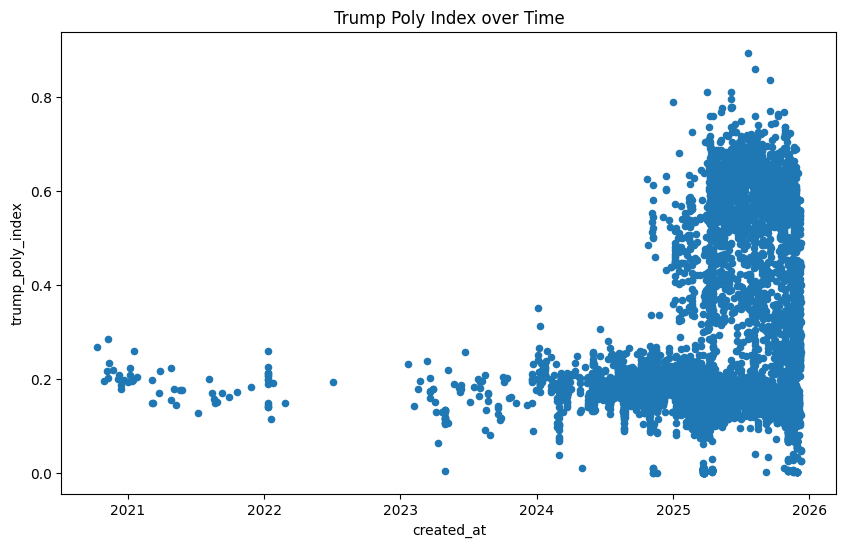

In [48]:
joined_trump_summary_stdprice_index.to_pandas().\
    plot(x='created_at', y='trump_poly_index', kind='scatter', title='Trump Poly Index over Time', figsize=(10, 6))

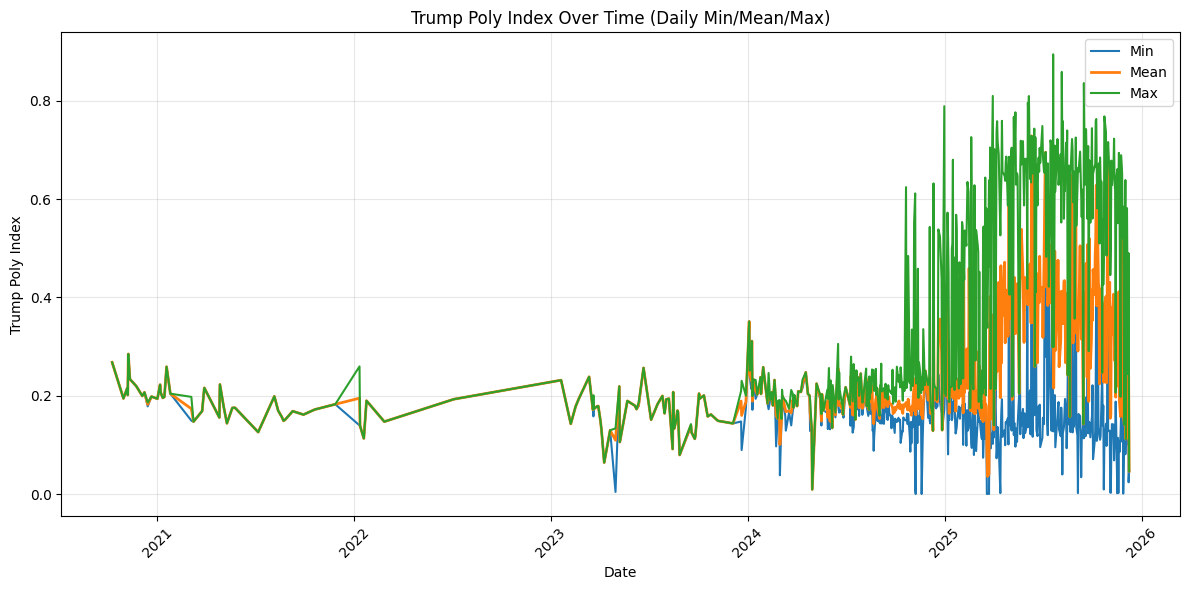

In [49]:
df__trump_poly_idx = joined_trump_summary_stdprice_index.to_pandas()

daily = (
    df__trump_poly_idx.dropna(subset=["created_at", "trump_poly_index"])
          .assign(date=df__trump_poly_idx["created_at"].dt.date)
          .groupby("date")["trump_poly_index"]
          .agg(["min", "mean", "max"])
          .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(daily["date"], daily["min"], label="Min", linewidth=1.5)
plt.plot(daily["date"], daily["mean"], label="Mean", linewidth=2)
plt.plot(daily["date"], daily["max"], label="Max", linewidth=1.5)
plt.title("Trump Poly Index Over Time (Daily Min/Mean/Max)")
plt.xlabel("Date")
plt.ylabel("Trump Poly Index")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
joined_trump_summary_stdprice_index.write_parquet(PROJECT_ROOT / "data" / "joined_trump_summary_std_token_price_index.parquet")

finance_politics_event_stats.parquet  

In [51]:
# markets_df = pl.scan_parquet(markets_path).collect()
fin_politics_event_stats_path = os.path.join(POLYMARKET_DIR, "finance_politics_event_stats.parquet" )
fin_pol_events = pl.scan_parquet(fin_politics_event_stats_path).collect()
fin_pol_events

event_slug,market_count,total_volume,first_market_start,last_market_end
str,i64,f64,datetime[μs],datetime[μs]
"""will-binancecom-become-insolve…",1,269.41,2023-01-24 21:09:31,2023-02-28 00:00:00
"""gme-market-cap-on-may-17""",7,112281.62,2024-05-13 17:51:35,2024-05-17 12:00:00
"""republican-vp-nominee""",25,9.2566e7,2024-01-18 19:14:19,2024-09-08 12:00:00
"""will-kevin-mccarthy-resign-fro…",1,6410.89,2023-11-12 19:11:54,2023-11-30 00:00:00
"""safe-market-cap-fdv-one-week-a…",6,116716.82,2024-03-26 17:01:59,2024-12-31 12:00:00
…,…,…,…,…
"""eth-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""sol-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""btc-updown-15m-1765431000""",1,267.31,2025-12-10 05:32:19,2025-12-11 05:45:00


In [52]:
fin_pol_events['event_slug'][0]

'will-binancecom-become-insolvent-by-feb-28-2023'

In [53]:
df_event_stats

event_slug,market_count,total_volume,first_market_start,last_market_end
str,i64,f64,datetime[μs],datetime[μs]
"""will-binancecom-become-insolve…",1,269.41,2023-01-24 21:09:31,2023-02-28 00:00:00
"""gme-market-cap-on-may-17""",7,112281.62,2024-05-13 17:51:35,2024-05-17 12:00:00
"""republican-vp-nominee""",25,9.2566e7,2024-01-18 19:14:19,2024-09-08 12:00:00
"""will-kevin-mccarthy-resign-fro…",1,6410.89,2023-11-12 19:11:54,2023-11-30 00:00:00
"""safe-market-cap-fdv-one-week-a…",6,116716.82,2024-03-26 17:01:59,2024-12-31 12:00:00
…,…,…,…,…
"""eth-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""sol-updown-4h-1765429200""",1,0.0,2025-12-10 05:01:33,2025-12-11 09:00:00
"""btc-updown-15m-1765431000""",1,267.31,2025-12-10 05:32:19,2025-12-11 05:45:00


In [54]:
print("End of EDA")

End of EDA
